# Visualization of Centrality Measures

In [1]:
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import numpy as np
from networkx.algorithms import community

In [2]:
#leverage centrality can assign negative values to a node, indicating that node has less connections than its neighbours. In this case, a node is said to be influenced by its neighbours.
def levarageCentrality(G):
    nodes = list(G.nodes)
    degrees = G.degree
    leverageCentrality ={}
    for node in nodes:
        if(len(list(G.neighbors(node)))==0):
            leverageCentrality[node] = 0
        else:
            leverage=0
            for n in G.neighbors(node):
                leverage += (degrees[node]-degrees[n]) / (degrees[node]+degrees[n])

            leverageCentrality[node] = round(((1/degrees[node]) * leverage),4)

    return leverageCentrality

def averageNeighborDegree(G):
    nodes = list(G.nodes)
    degrees = G.degree
    averageNeighborDegree ={}
    for node in nodes:
        neighborsDegree=0
        if(len(list(G.neighbors(node)))==0):
            averageNeighborDegree[node] = 0
        else:
            for n in G.neighbors(node):
                neighborsDegree += degrees[n]

            averageNeighborDegree[node] = neighborsDegree/degrees[node]

    return averageNeighborDegree

def bridgingCentrality(G):
    nodes = list(G.nodes)
    degrees = G.degree
    #betweenness
    bet = nx.betweenness_centrality(G)
    #bridging centrality
    bridging_centrality={}

    for node in nodes:
        if(degrees[node]!=0):
            nodeDegreeInverse = degrees[node]**-1
            neighborsDegreeInverse=0
            for n in G.neighbors(node):
                neighborsDegreeInverse += degrees[n]**-1

            bridging_centrality[node] = (nodeDegreeInverse/neighborsDegreeInverse) * bet[node]
        else:
            bridging_centrality[node] = 0
    return bridging_centrality


def pacticipantionCoefficient(G):
# Ref: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012200
# Ref2: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220061

    pacticipantionCefficient={}
    communities = community.greedy_modularity_communities(G)
    numberOfModules = len(communities)
    for node in G.nodes:  
        neighbors = list(G.neighbors(node))
        #Avoid CC of size one
        if(len(neighbors)!=0):            
            pacticipantionCefficient[node]=0
            for com in communities:  
                neighborsInComunities=0
                for n in neighbors:
                    if n in com:
                        neighborsInComunities+=1
                if(neighborsInComunities>0):
                    pacticipantionCefficient[node]+=( (neighborsInComunities/len(neighbors) )**2)

            pacticipantionCefficient[node] = 1-pacticipantionCefficient[node] 
        else:
            pacticipantionCefficient[node] = 0
    return pacticipantionCefficient

In [3]:
def networkMeasuresAsDF(G):
    #Extract the measures
    degree = nx.degree(G)
    closeness = nx.closeness_centrality(G)
    betweeness = nx.betweenness_centrality(G)
    clustering = nx.clustering(G)
    kcore = nx.core.core_number(G)
    eigenvector = nx.eigenvector_centrality(G)
    leverage = levarageCentrality(G)
    averageNeighbor = averageNeighborDegree(G)
    bridging = bridgingCentrality(G)
    participation = pacticipantionCoefficient(G)

    #Create a dataframe using the measures 
    networkMeasures = pd.DataFrame(pd.DataFrame.from_dict(dict(degree),orient='index',columns=['Degree']))

    df = pd.DataFrame.from_dict(dict(clustering),orient='index',columns=['Clustering'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)
    
    df = pd.DataFrame.from_dict(dict(kcore),orient='index',columns=['Kcore'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)
    
    df = pd.DataFrame.from_dict(dict(eigenvector),orient='index',columns=['Eigenvector'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)
    
    df = pd.DataFrame.from_dict(dict(leverage),orient='index',columns=['Leverage'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)
    
    df = pd.DataFrame.from_dict(dict(averageNeighbor),orient='index',columns=['AvgNeighbors'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)
    
    df = pd.DataFrame.from_dict(dict(closeness),orient='index',columns=['Closeness'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)

    df = pd.DataFrame.from_dict(dict(betweeness),orient='index',columns=['Betweeness'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)    
    
    df = pd.DataFrame.from_dict(dict(bridging),orient='index',columns=['Bridging'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)
    
    df = pd.DataFrame.from_dict(dict(participation),orient='index',columns=['Participation'])
    networkMeasures=pd.concat([networkMeasures,df],axis=1)
    
    return networkMeasures

def drawNetworkWithCMAP(G,measure,pos,labels=1):
    nodesSize=[]
    values=list(measure.values())
    values=[ (float(i)-min(values))/(max(values)-min(values)) if (max(values)-min(values))>0 else 0 for i in values ]
    vmin = min(values)
    vmax = max(values)
    for value in values:
        #No variation | Or no values
        if vmin == value:
            nodesSize.append(50)
        else:
            normalize = value/(vmax)
            if(normalize>=0.9):
                 nodesSize.append(150)
            elif(normalize>=0.75):
                 nodesSize.append(115)
            elif(normalize>=0.5):
                 nodesSize.append(90)
            elif(normalize>=0.25):
                 nodesSize.append(75)
            else:
                 nodesSize.append(50)
    
    cmap = plt.get_cmap('autumn_r')
    nx.draw(G, pos, with_labels=labels,node_size=nodesSize,font_size=6,font_color='#444',edge_color='gray', width=0.5,node_color=values,cmap=cmap, vmin=vmin*1, vmax=vmax*1)
#     print(measure)
#     print(nodesSize)
    
def plotMeasures(G,name):
    networkMeasures = networkMeasuresAsDF(G)
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(15,10),dpi=300)                        
    for i,col in enumerate(networkMeasures.columns):
        plt.subplot(3,4,i+1)
        plt.title(col,fontsize=16)
        measure =  dict(networkMeasures[col])
        drawNetworkWithCMAP(G,measure,pos,labels=0)
    plt.tight_layout()
    plt.savefig("ouput/2.2.2 AllMeasures_"+name+".png", format='png', dpi=550)
    plt.savefig("ouput/2.2.2 AllMeasures_"+name+".pdf", format='pdf')
    plt.show()
    plt.close()
    
def plotMeasures2_Pair(G1,G2):
    dictOfMeasures={}
    networkMeasures1 = networkMeasuresAsDF(G1)
    networkMeasures2 = networkMeasuresAsDF(G2)
    pos1 = nx.kamada_kawai_layout(G1)
    pos2 = nx.kamada_kawai_layout(G2)                          
    for col in networkMeasures1.columns:
        dictOfMeasures[col]={}
        plt.figure(figsize=(12,4),dpi=300)  
#         plt.suptitle(col,fontsize=13)
        #G1
        plt.subplot(1,2,1)        
        measure =  dict(networkMeasures1[col])
        drawNetworkWithCMAP(G1,measure,pos1,labels=1)
        #G2
        plt.subplot(1,2,2)        
        measure =  dict(networkMeasures2[col])
        drawNetworkWithCMAP(G2,measure,pos2,labels=1)
        plt.tight_layout()
#         plt.savefig("ouput/2.2.2 "+col+".png", format='png', dpi=550)
#         plt.savefig("ouput/2.2.2 "+col+".pdf", format='pdf')
        plt.show()
        plt.close()
    return dictOfMeasures

# Sample Networks

In [4]:
sample1 = nx.barabasi_albert_graph(35,1,seed=444444)
leafsOf1=[x for x in dict(sample1[2]).keys() if sample1.degree(x) ==1]
for i in leafsOf1:
    for j in leafsOf1:
        if(i!=j):
            sample1.add_edge(i,j)  
sample1.add_edge(3,35)
sample1.add_edge(3,36)
sample1.add_edge(26,34)
sample1.add_edges_from([(18,19),(19,21),(21,23)])

sample2=nx.tutte_graph()

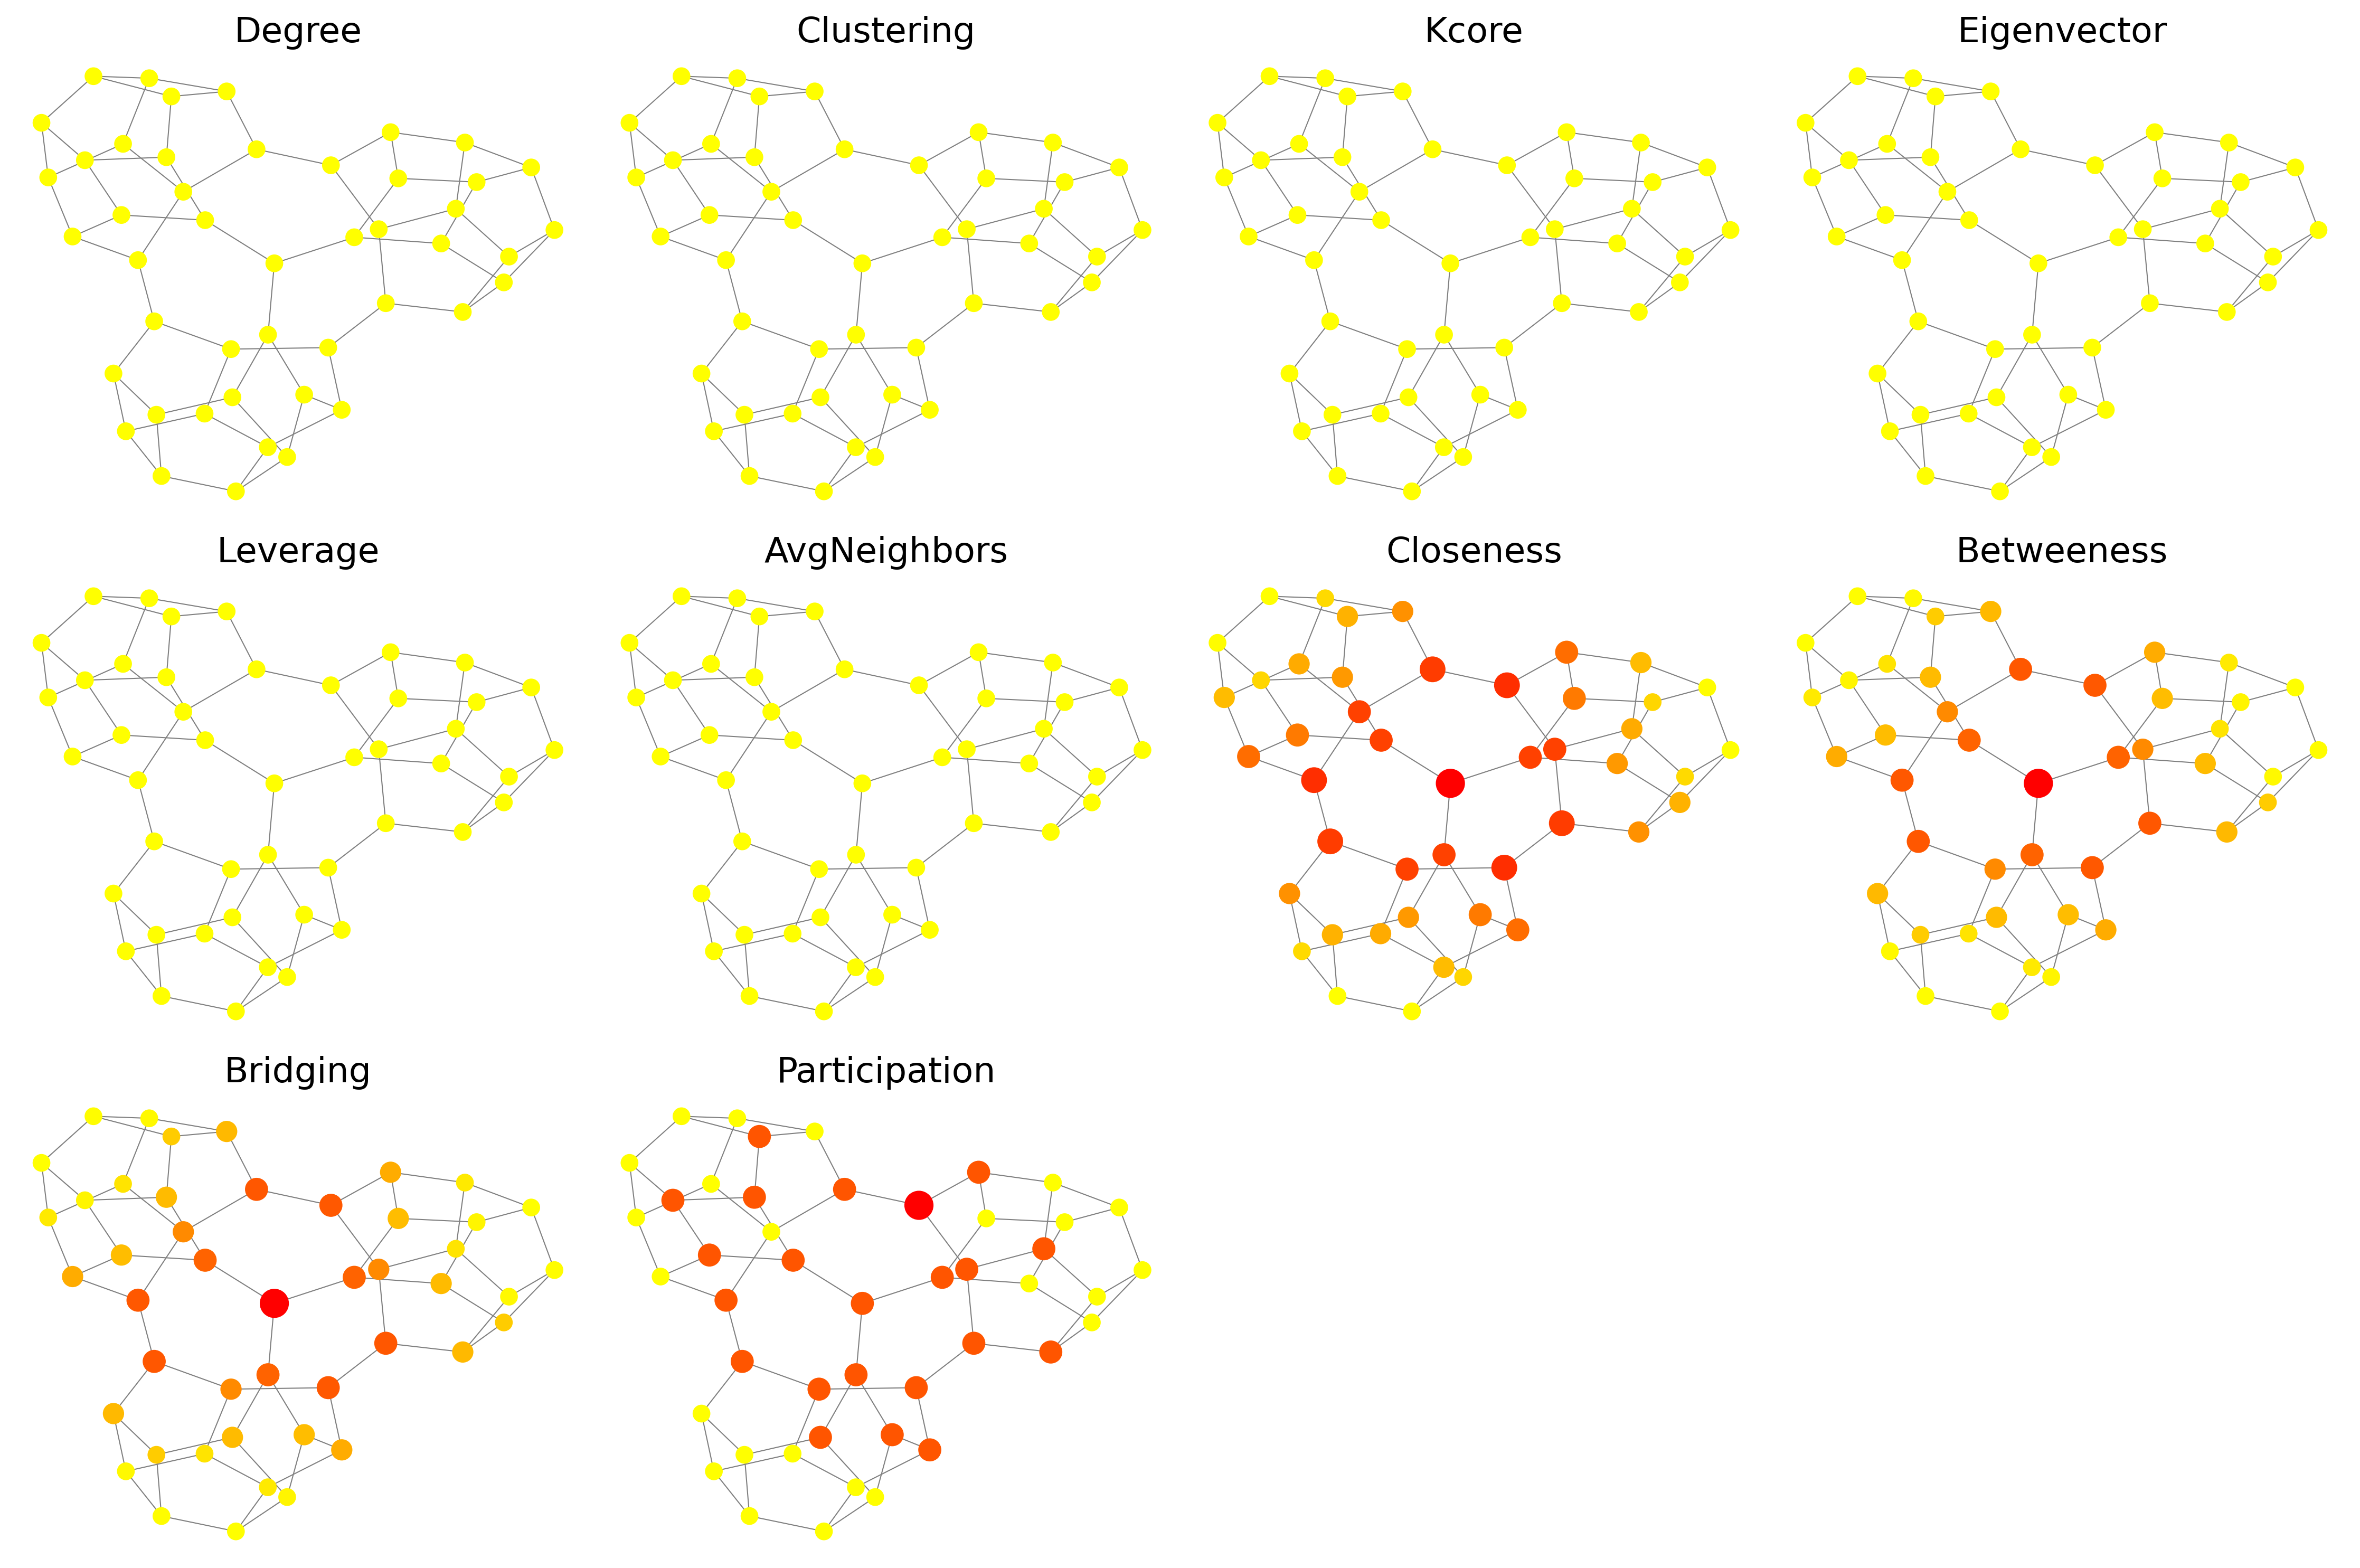

In [5]:
plotMeasures(sample2,'sample2')

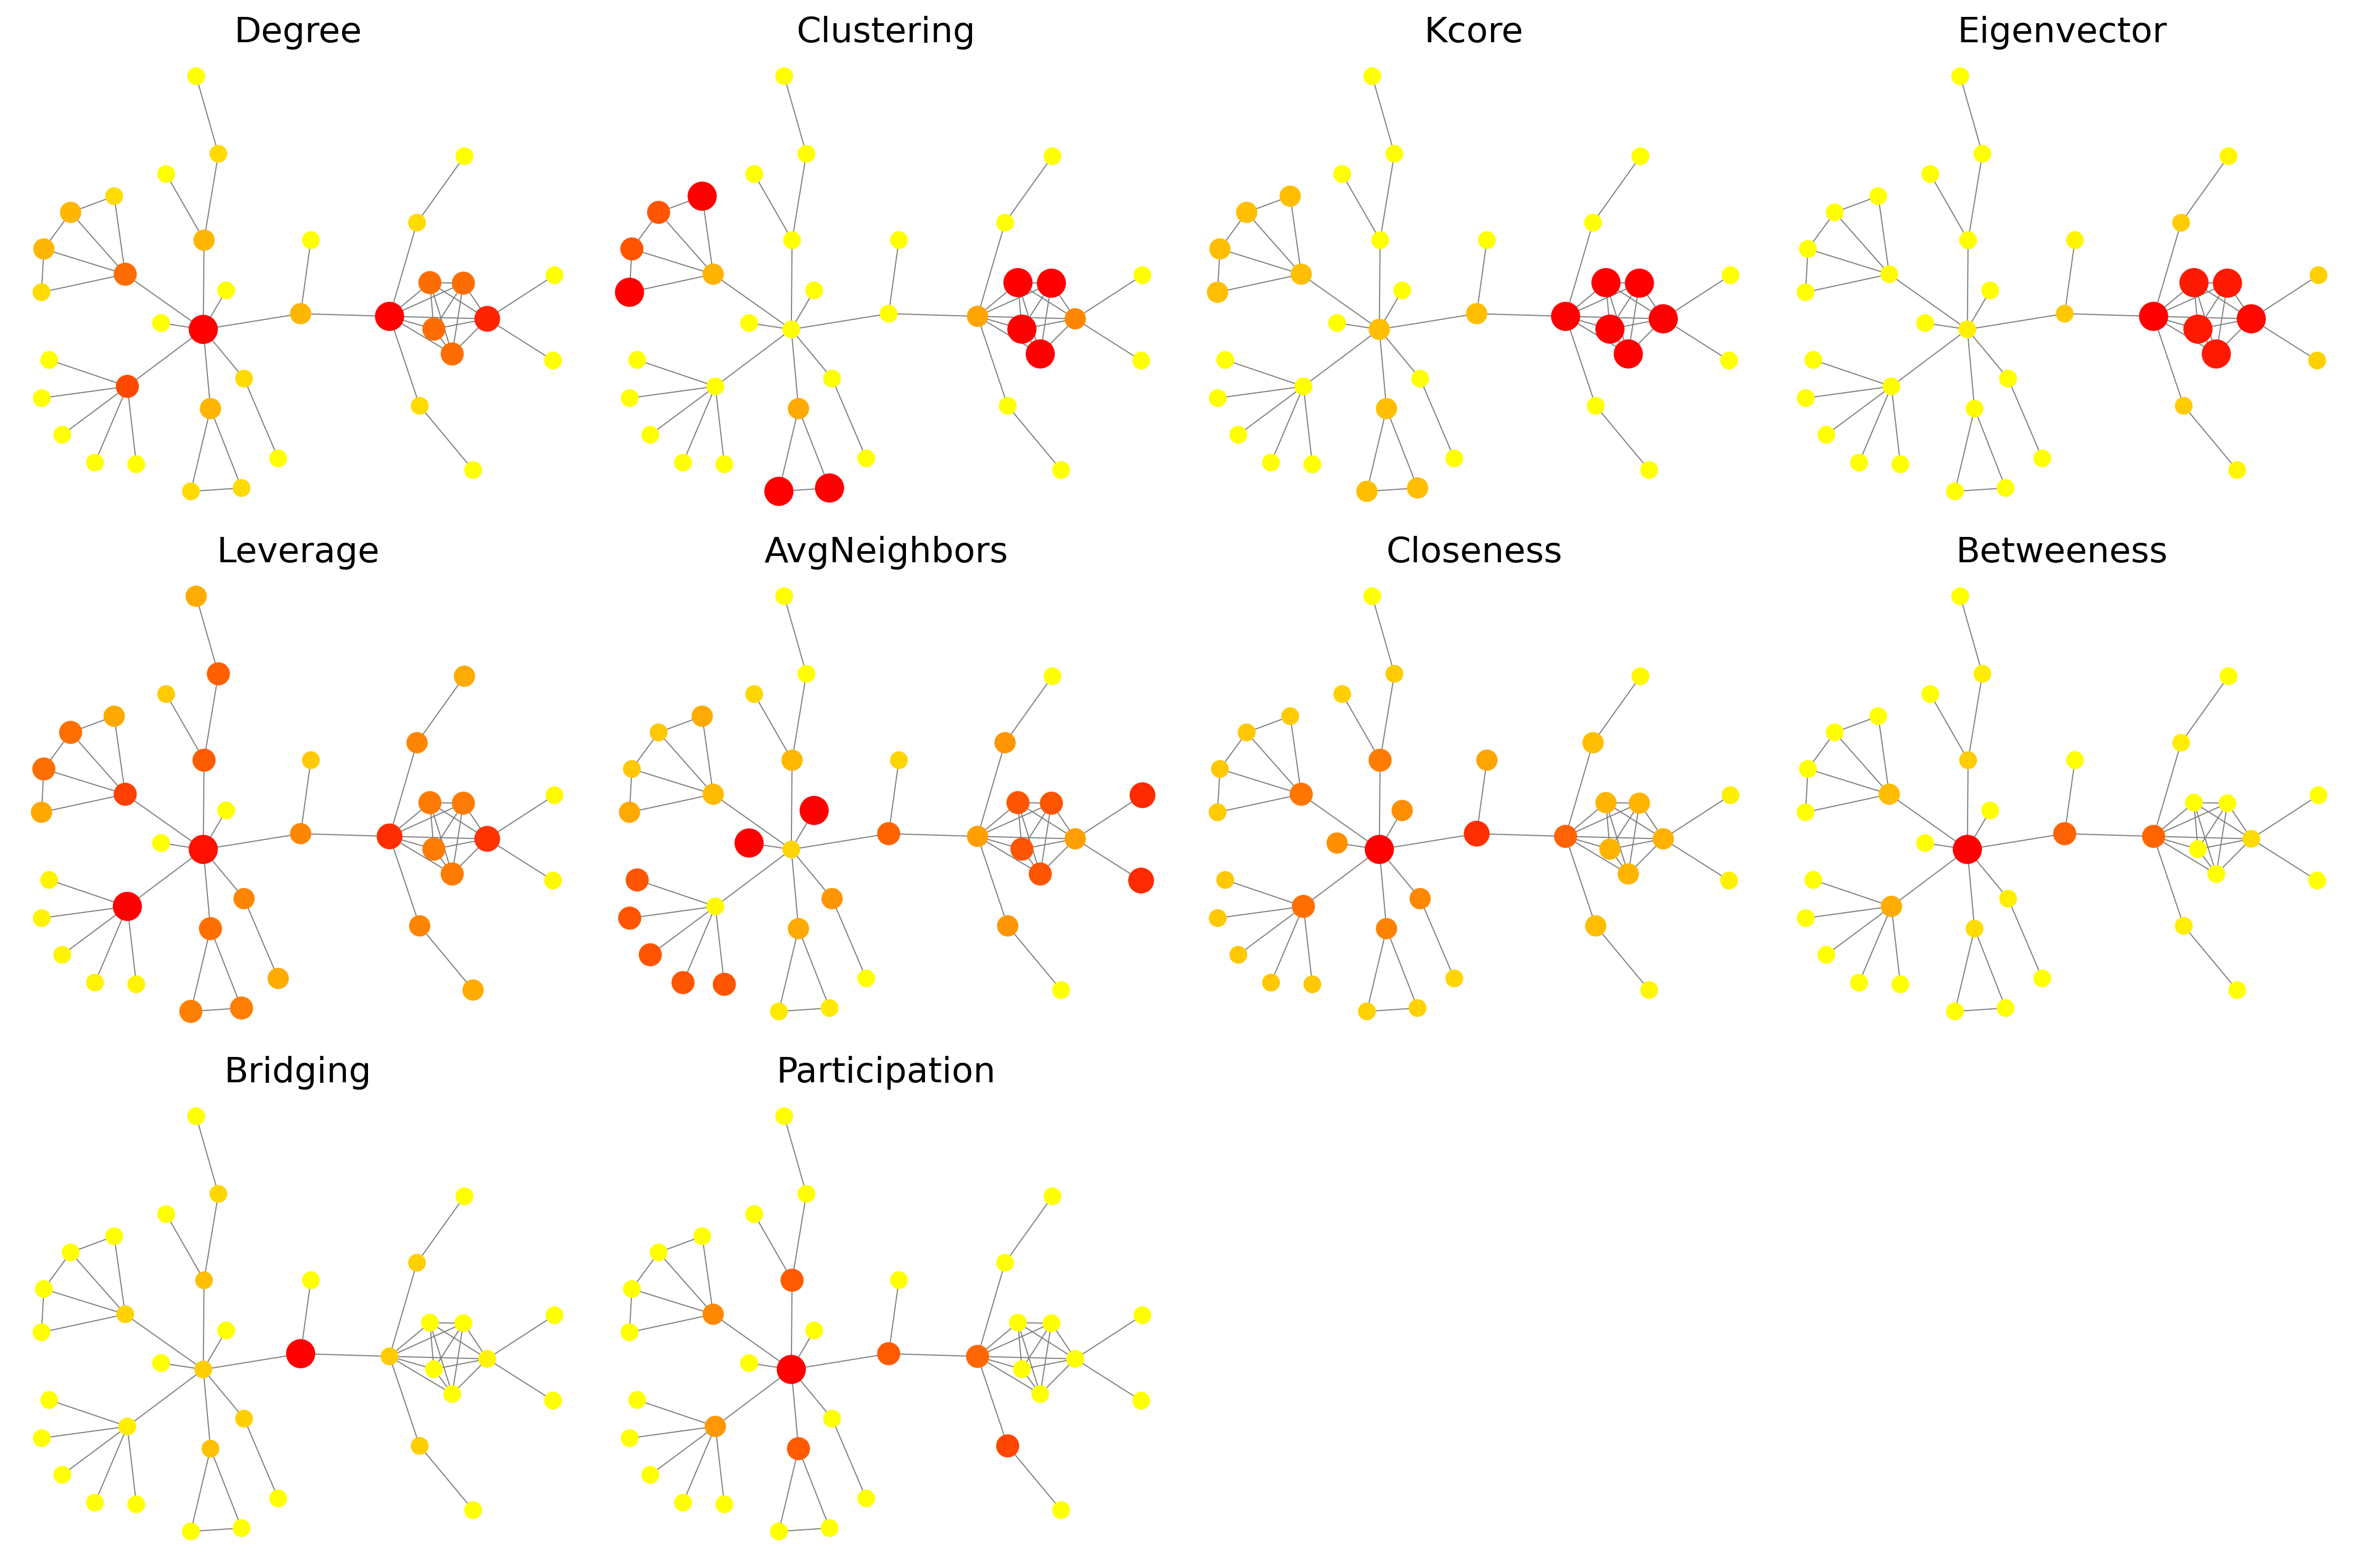

In [6]:
plotMeasures(sample1,'sample1')

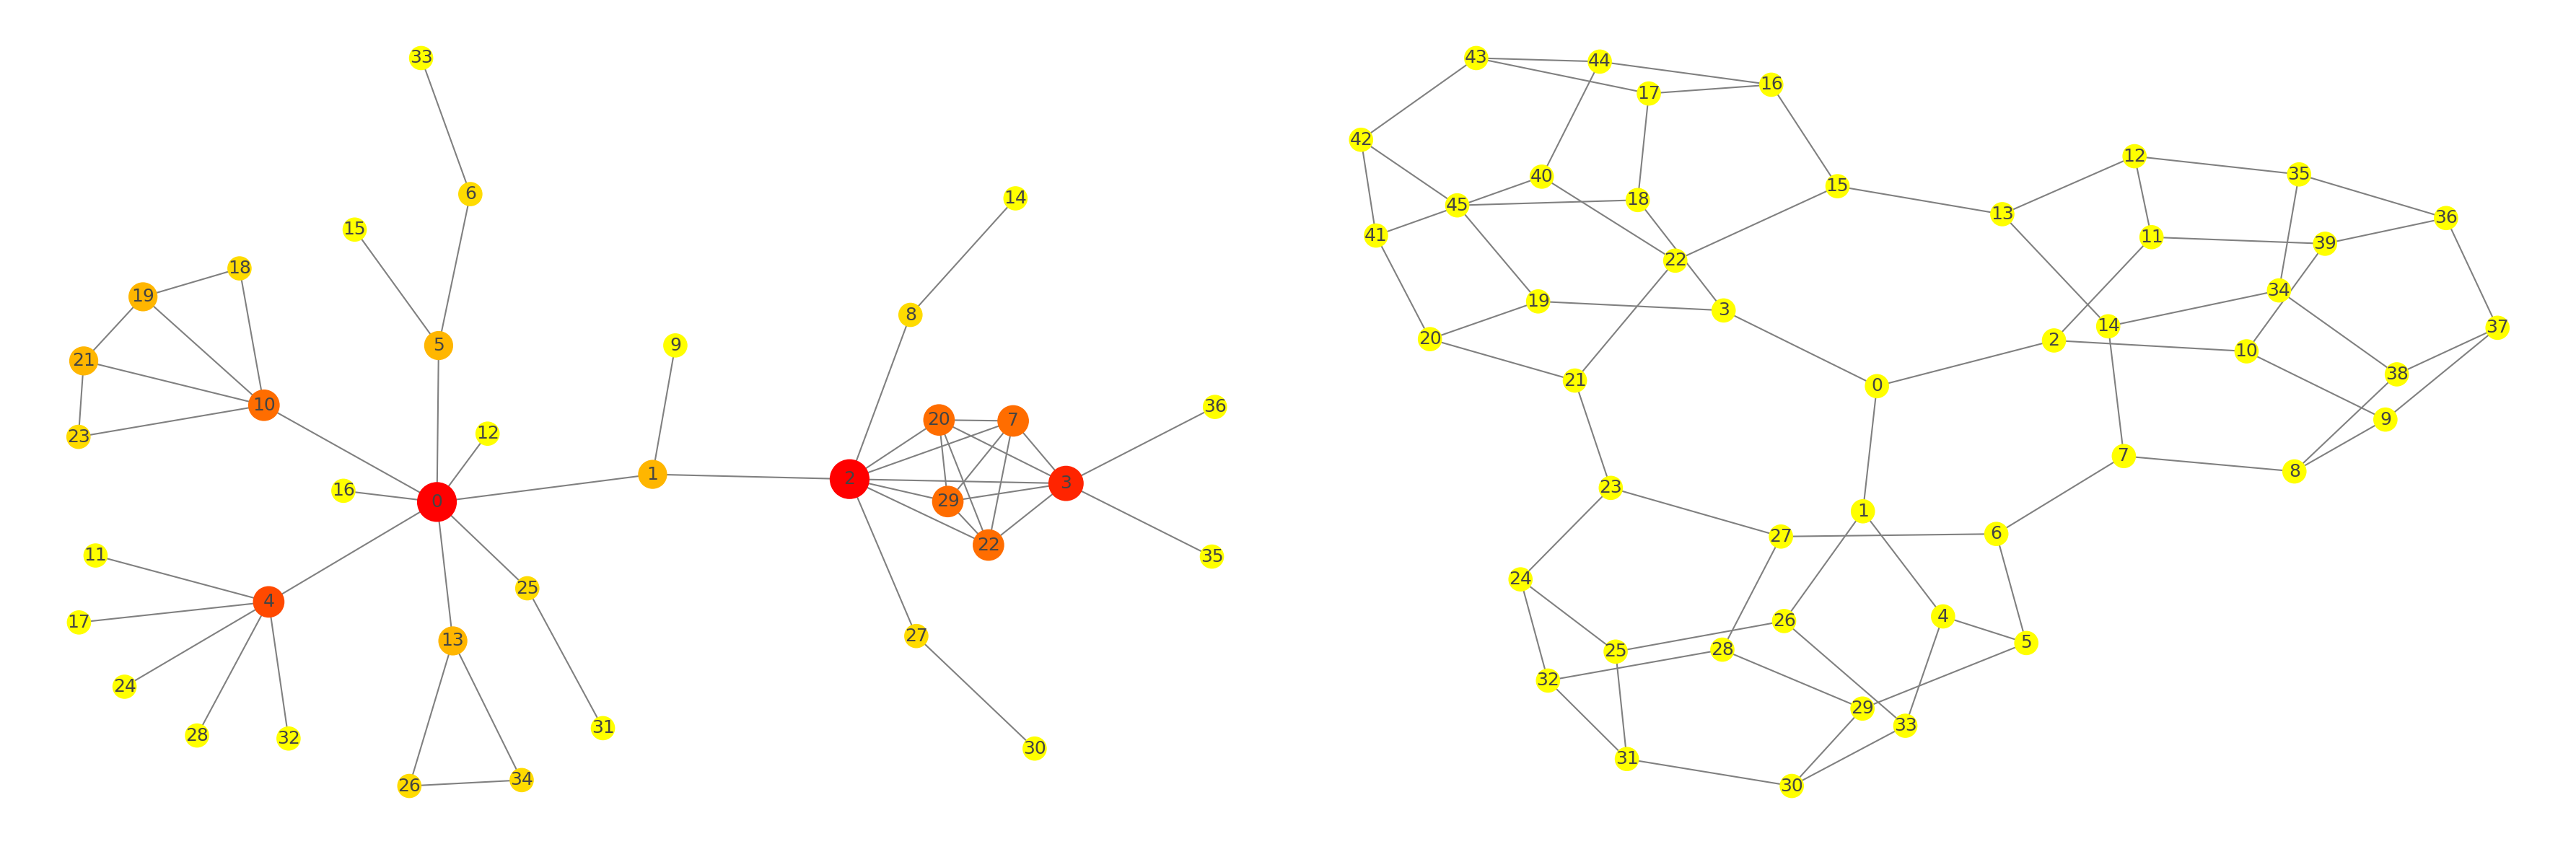

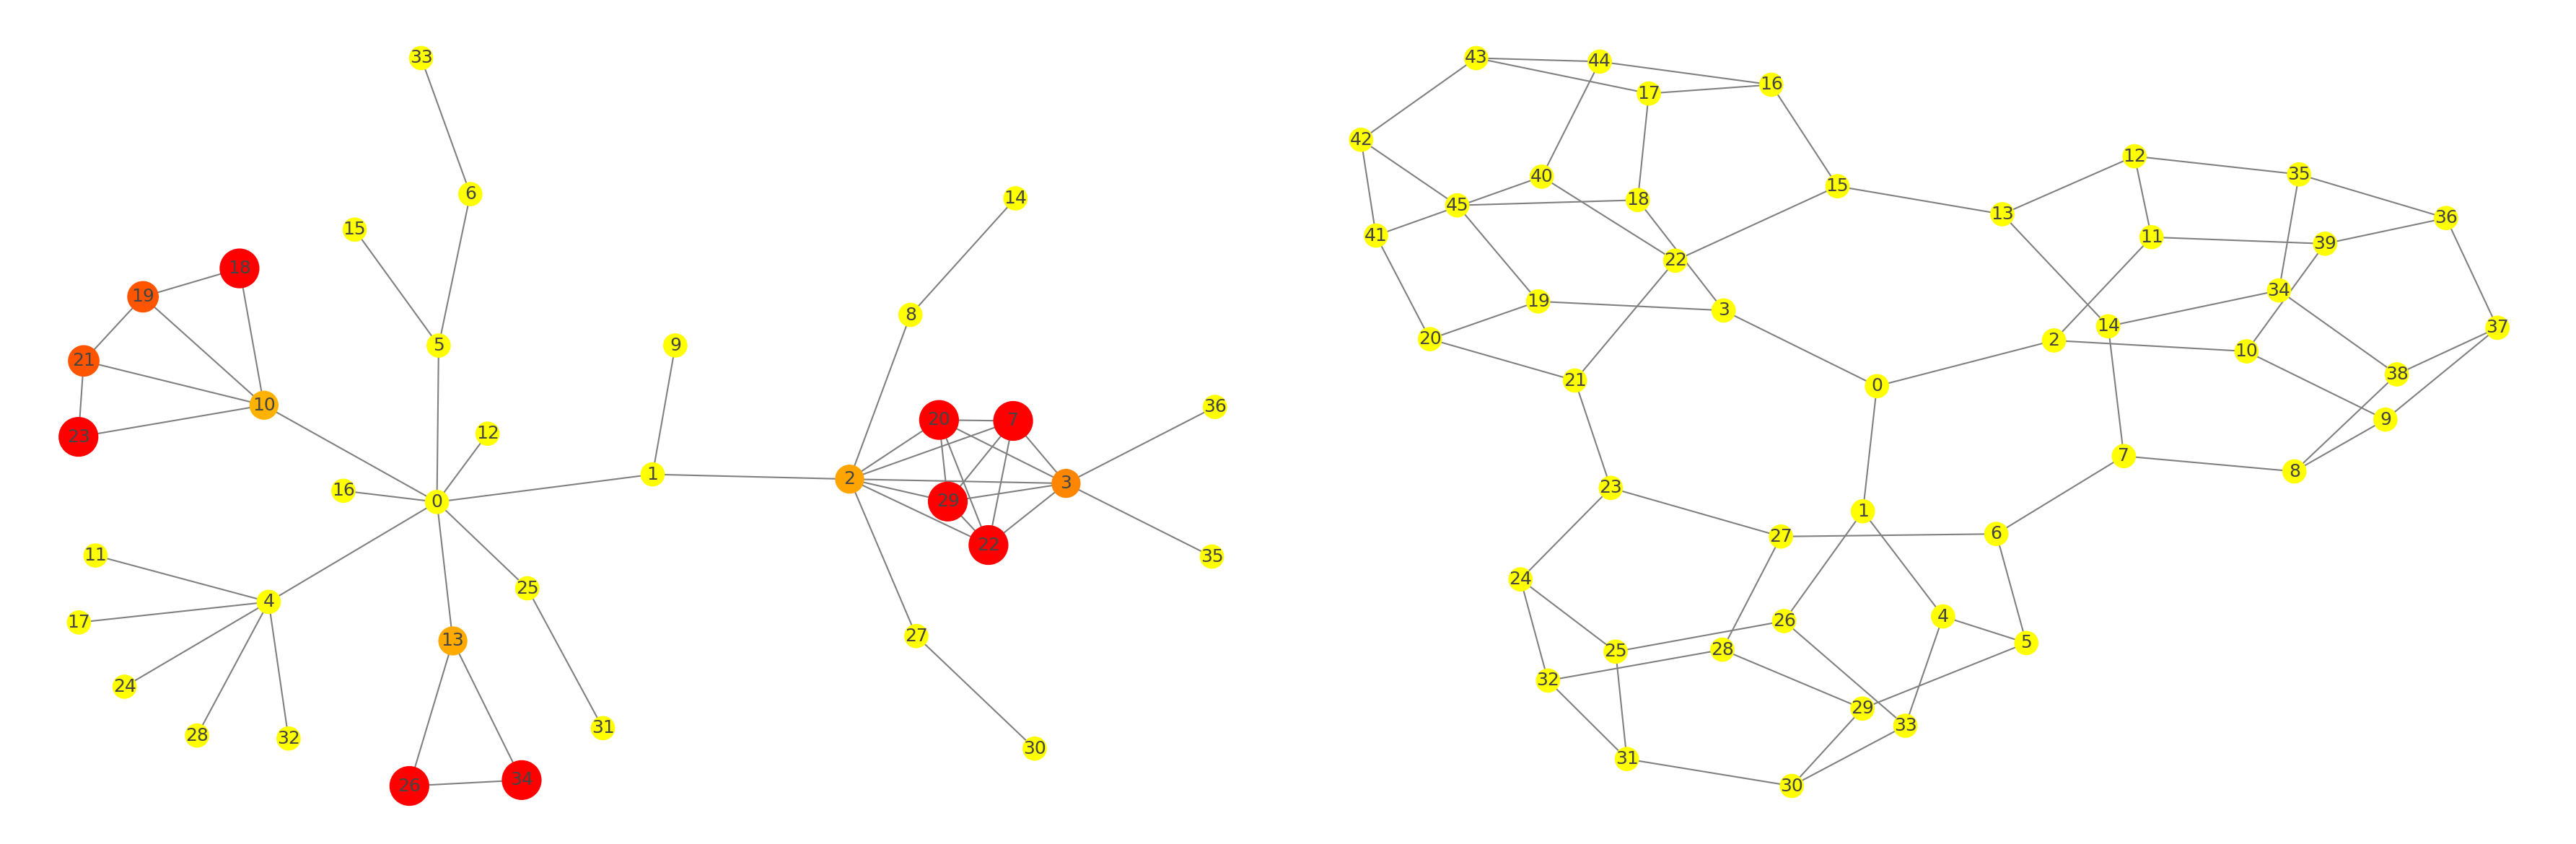

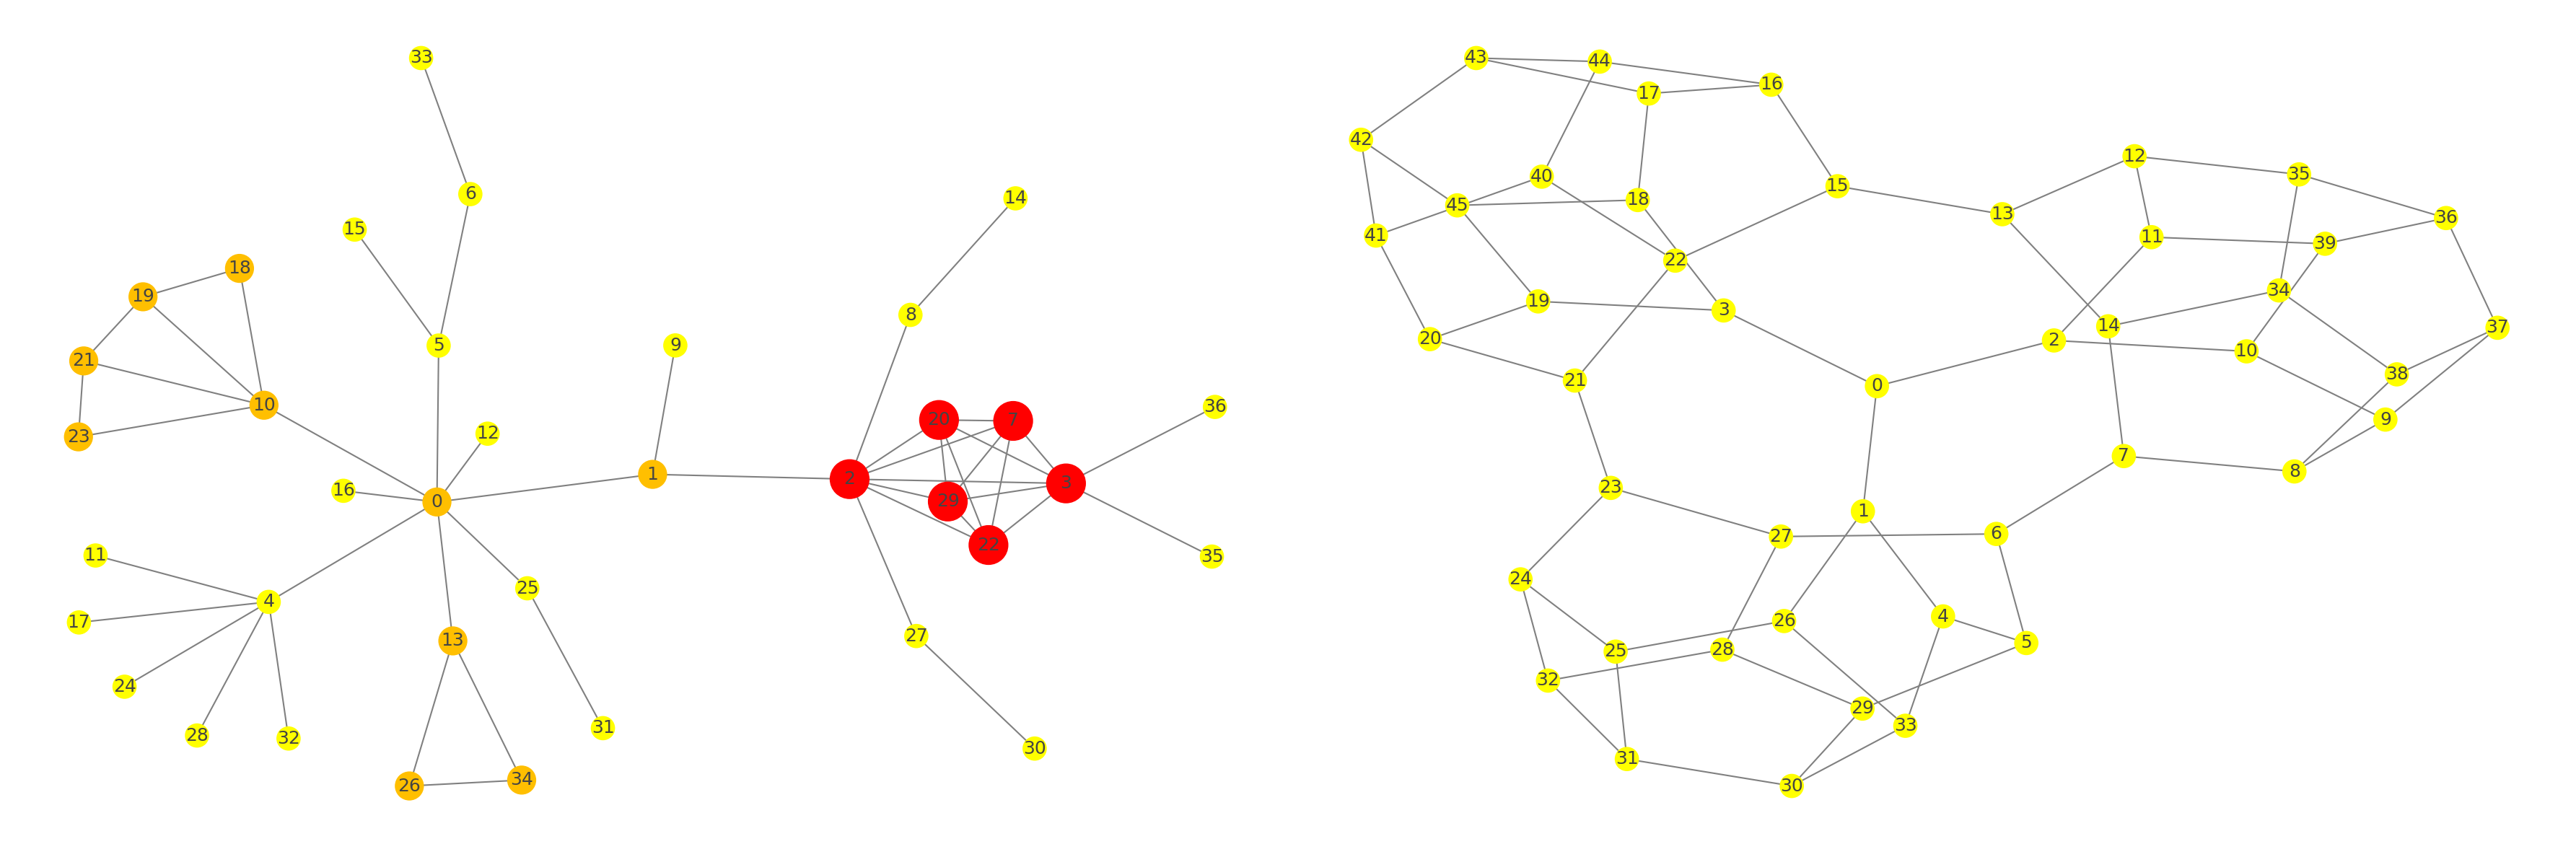

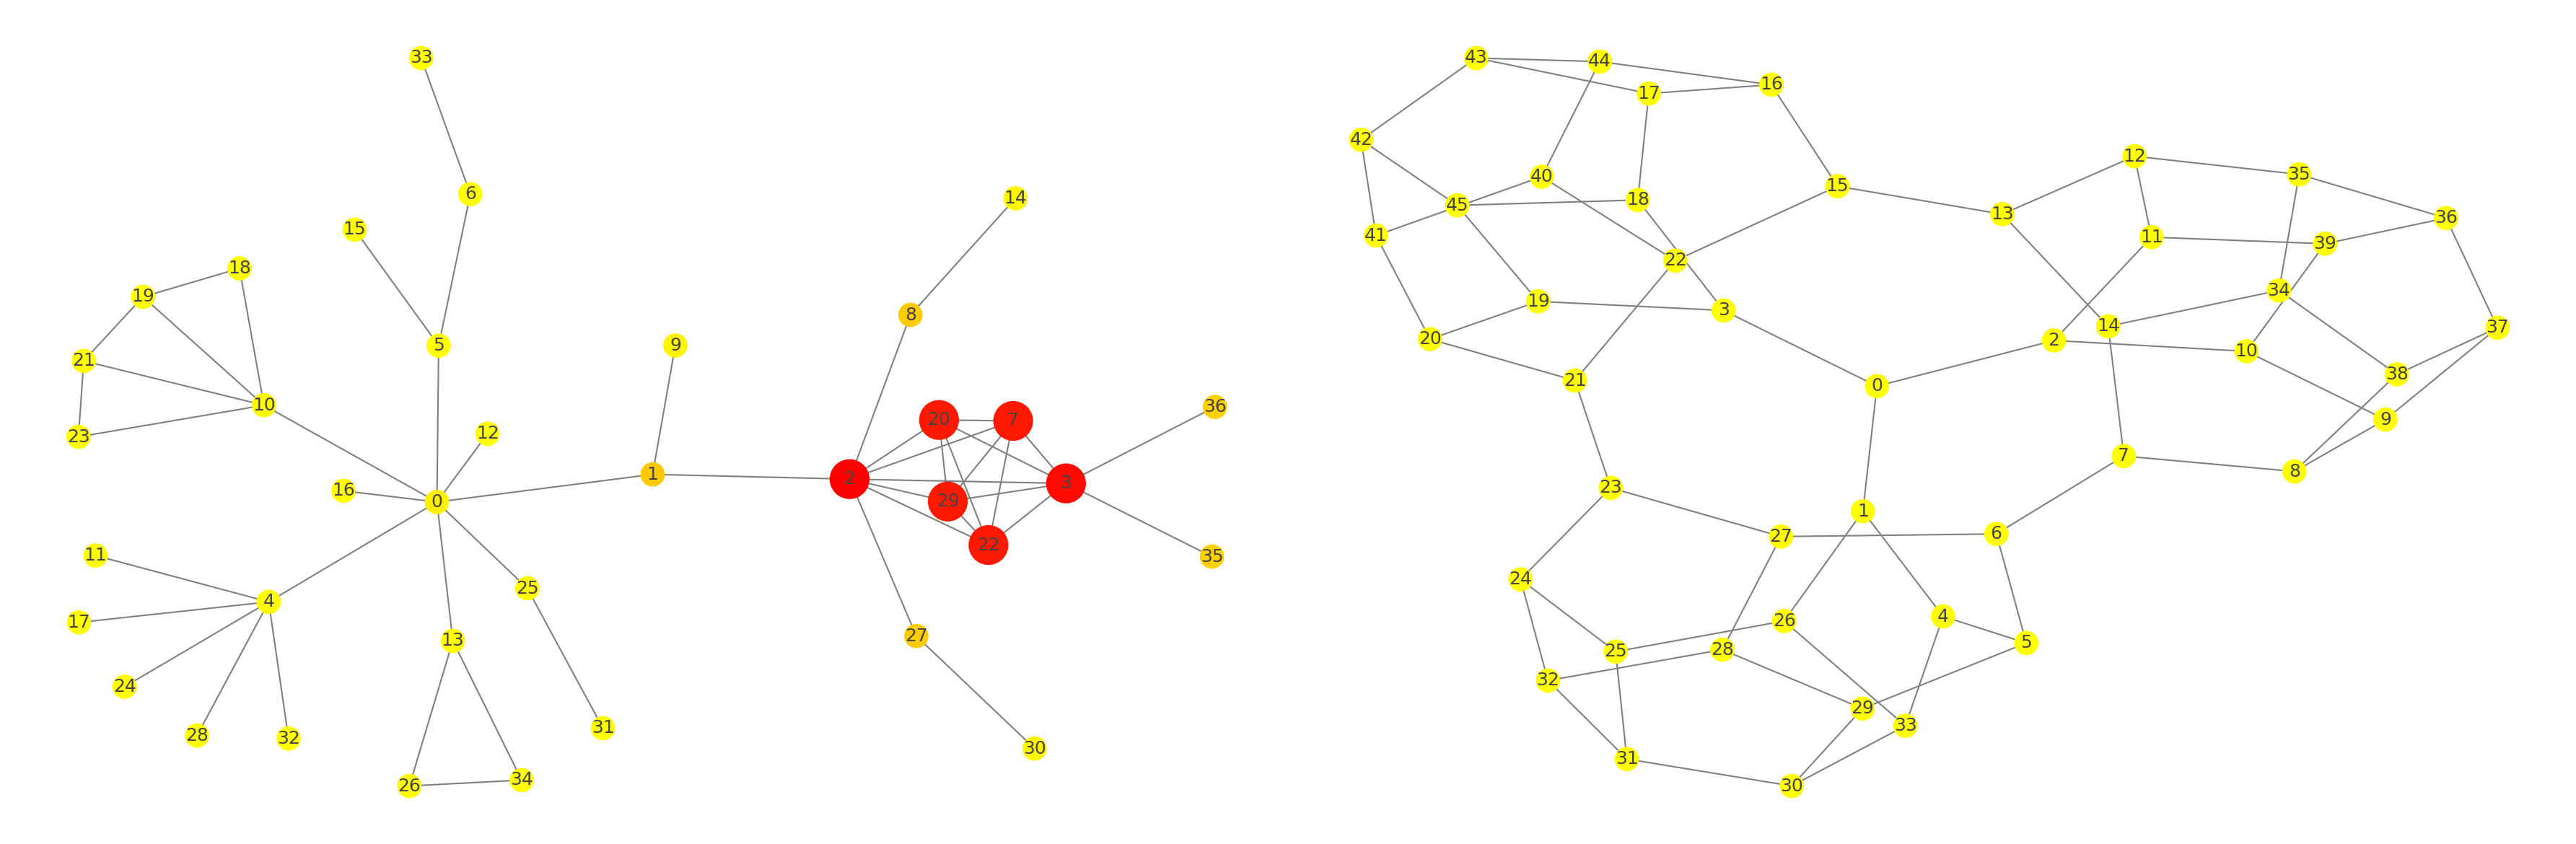

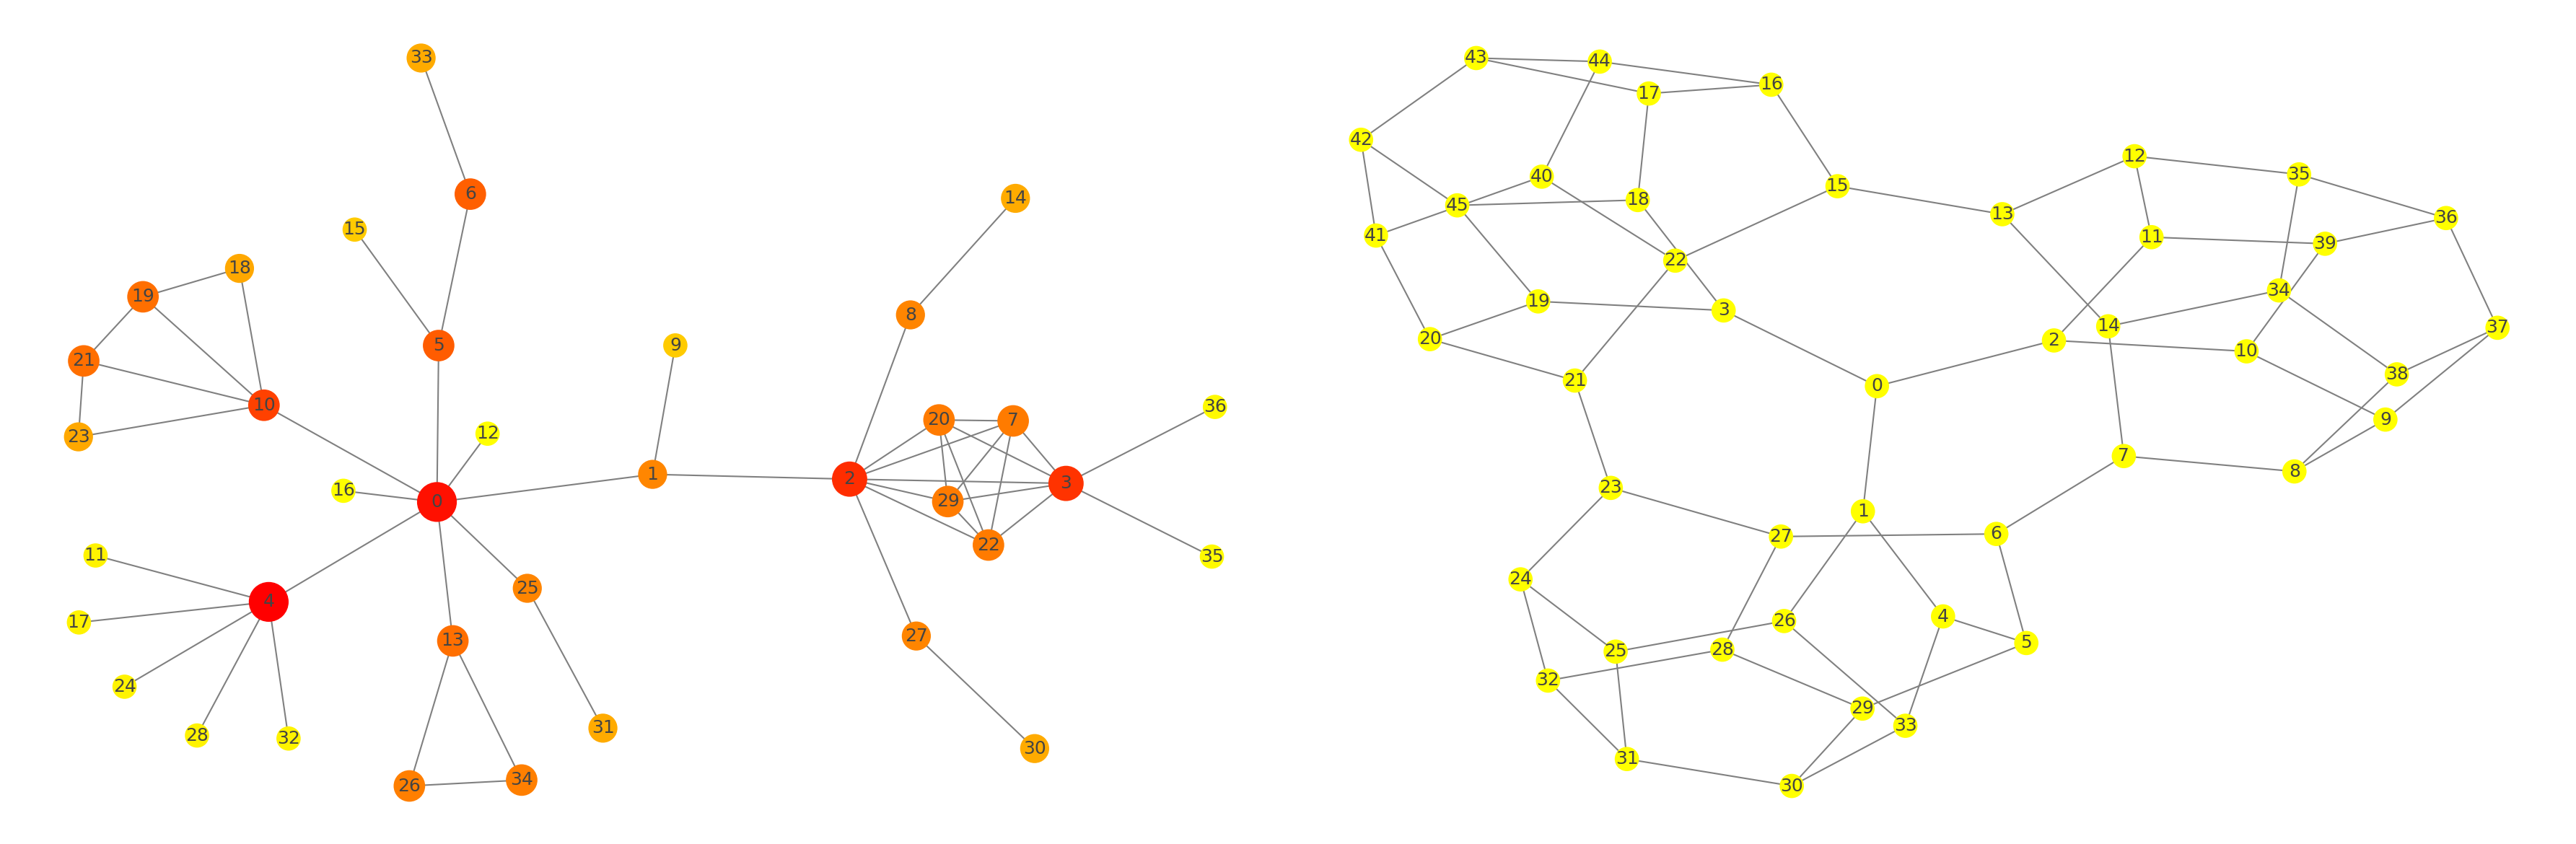

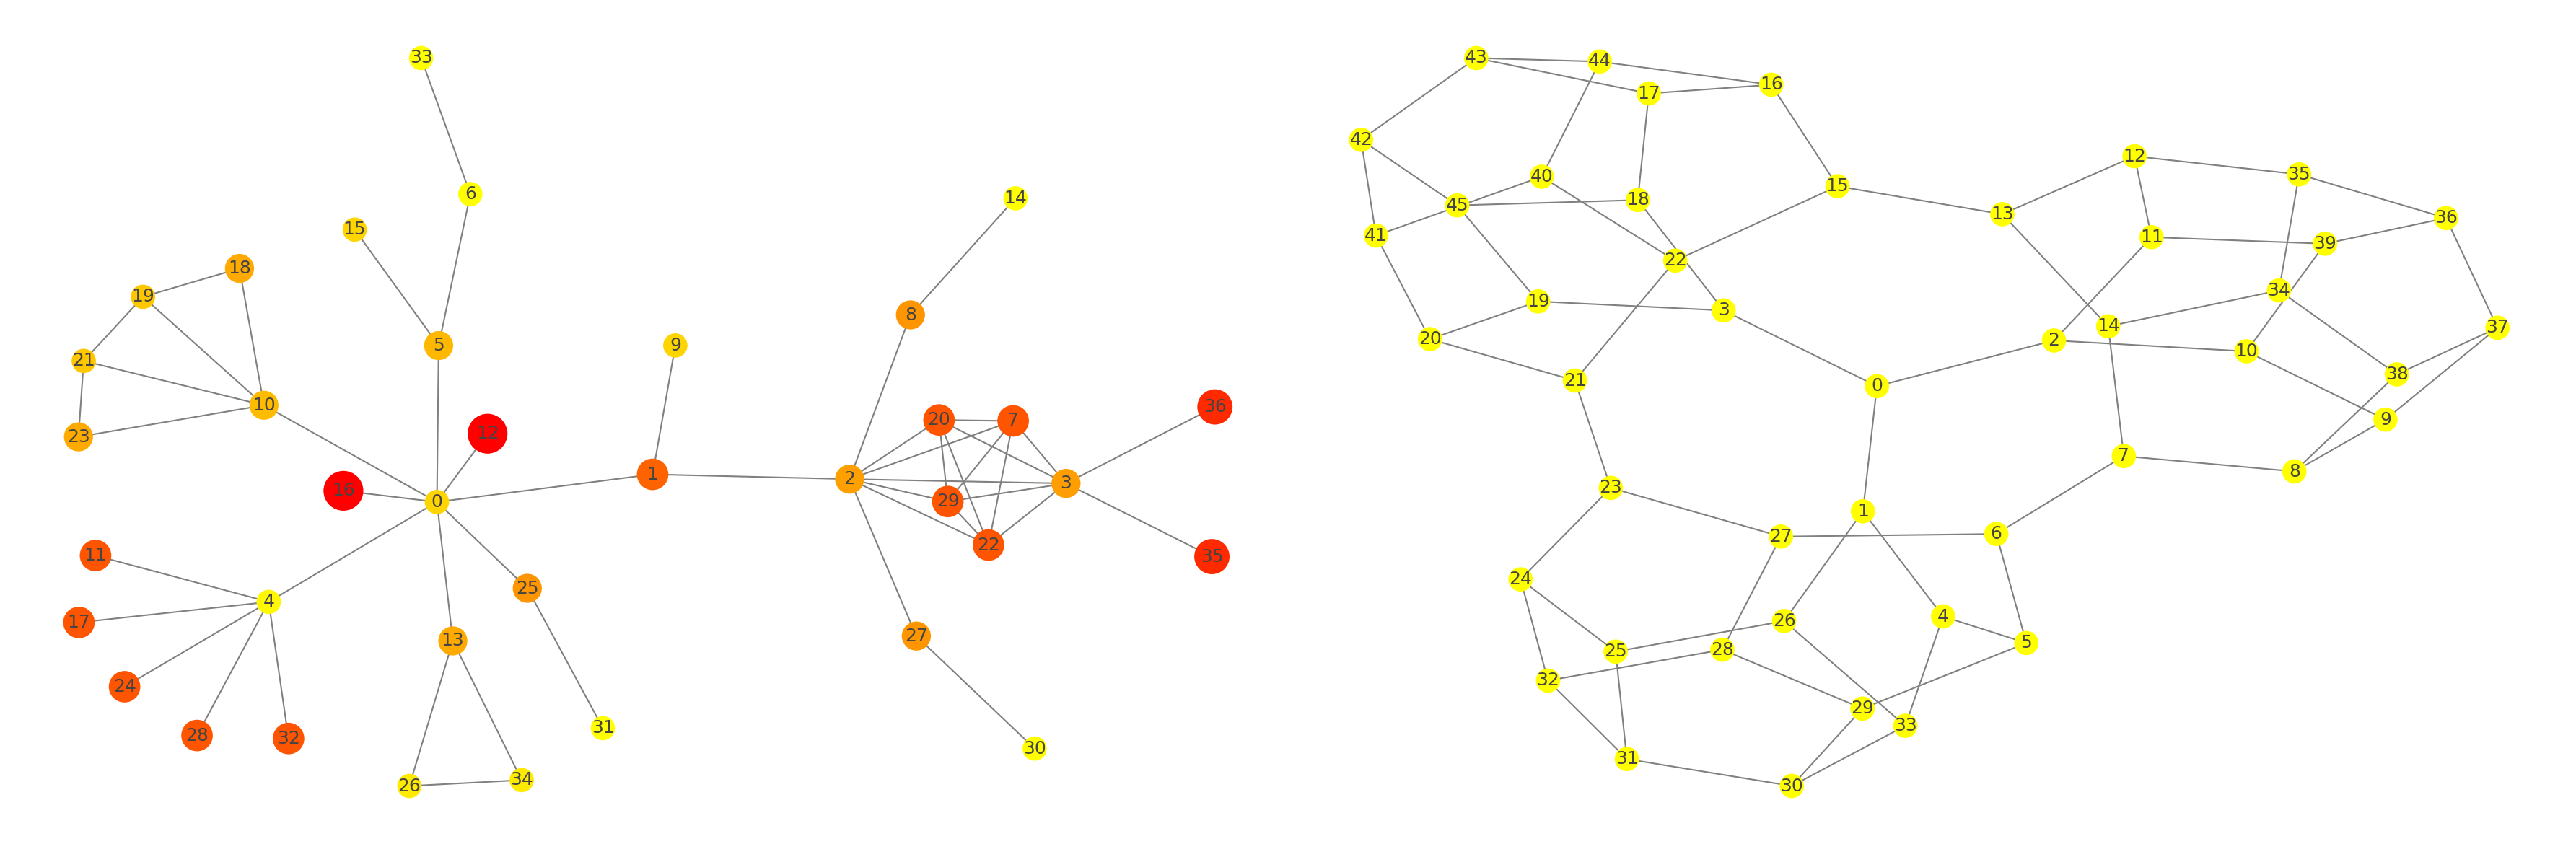

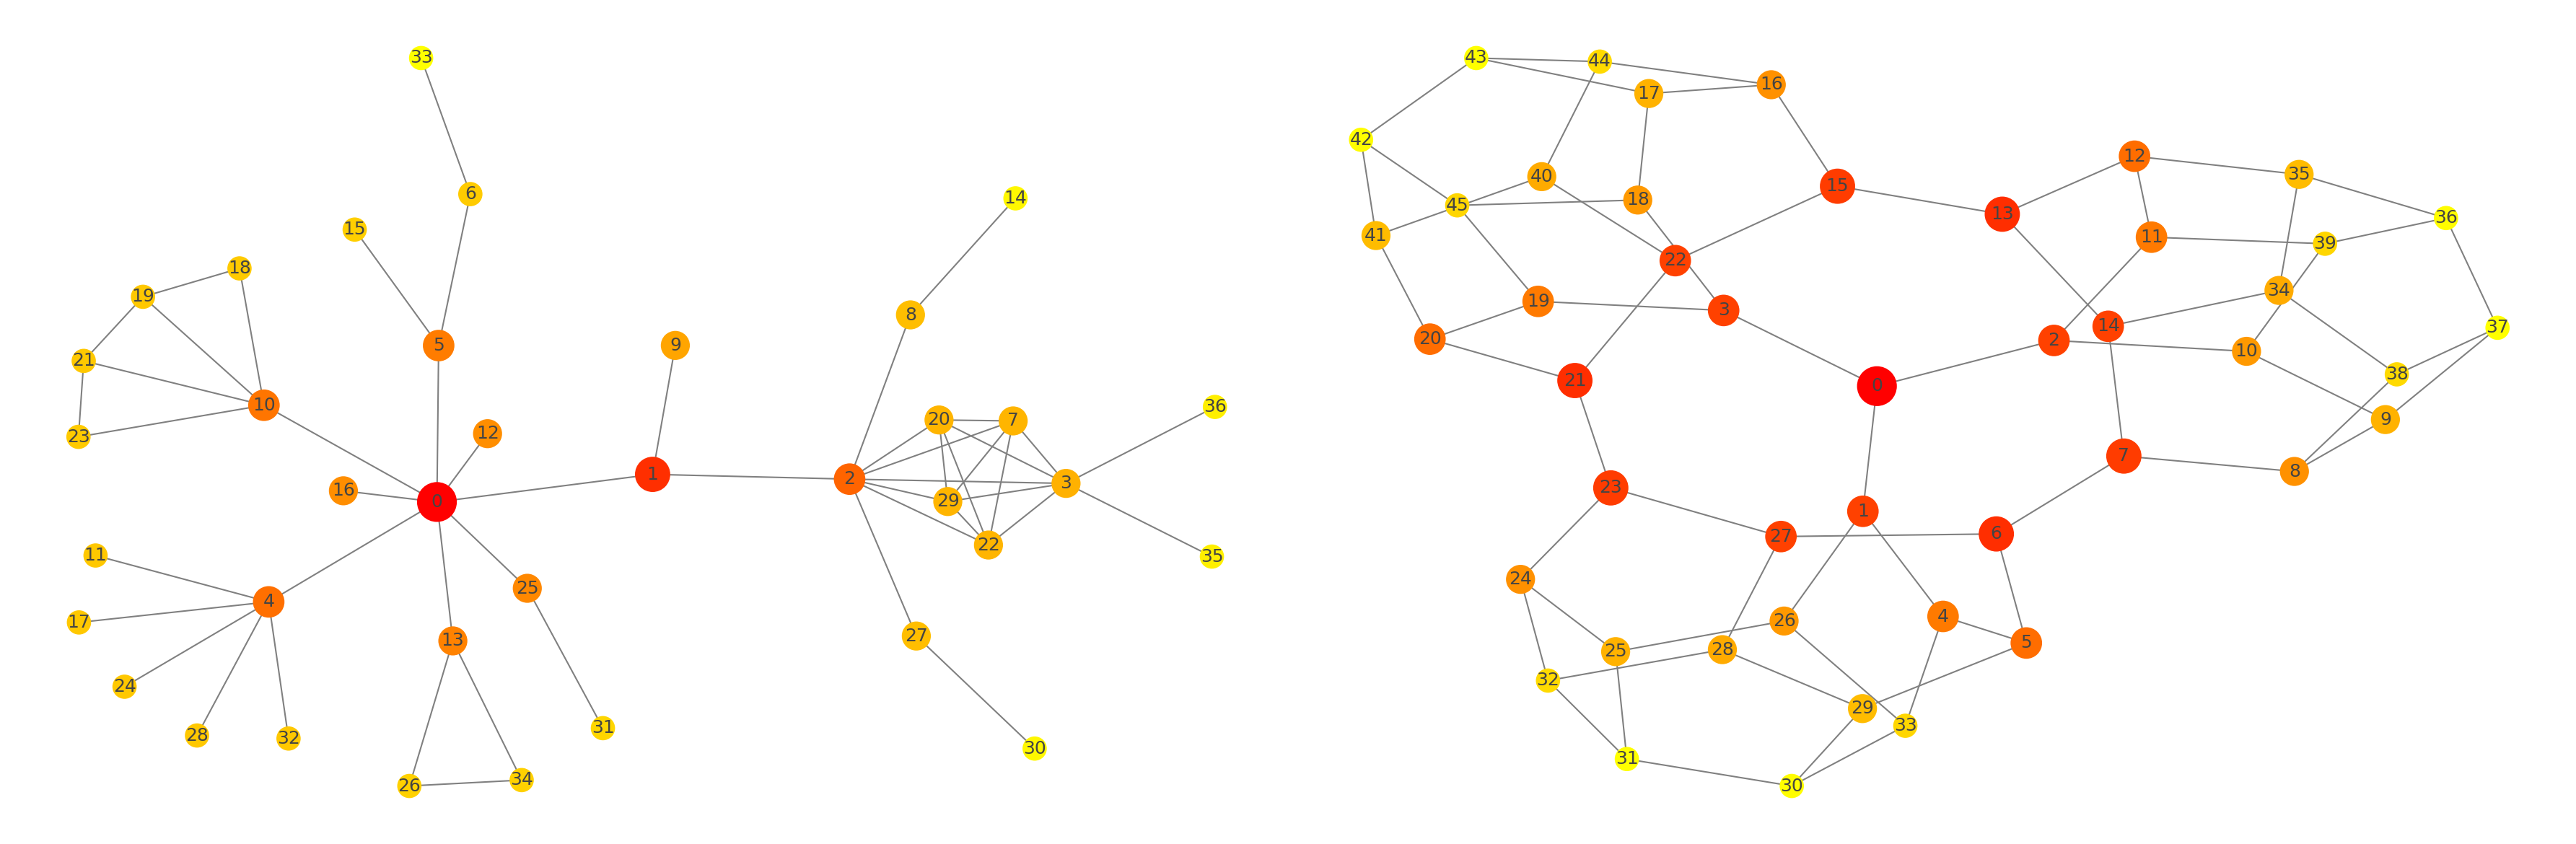

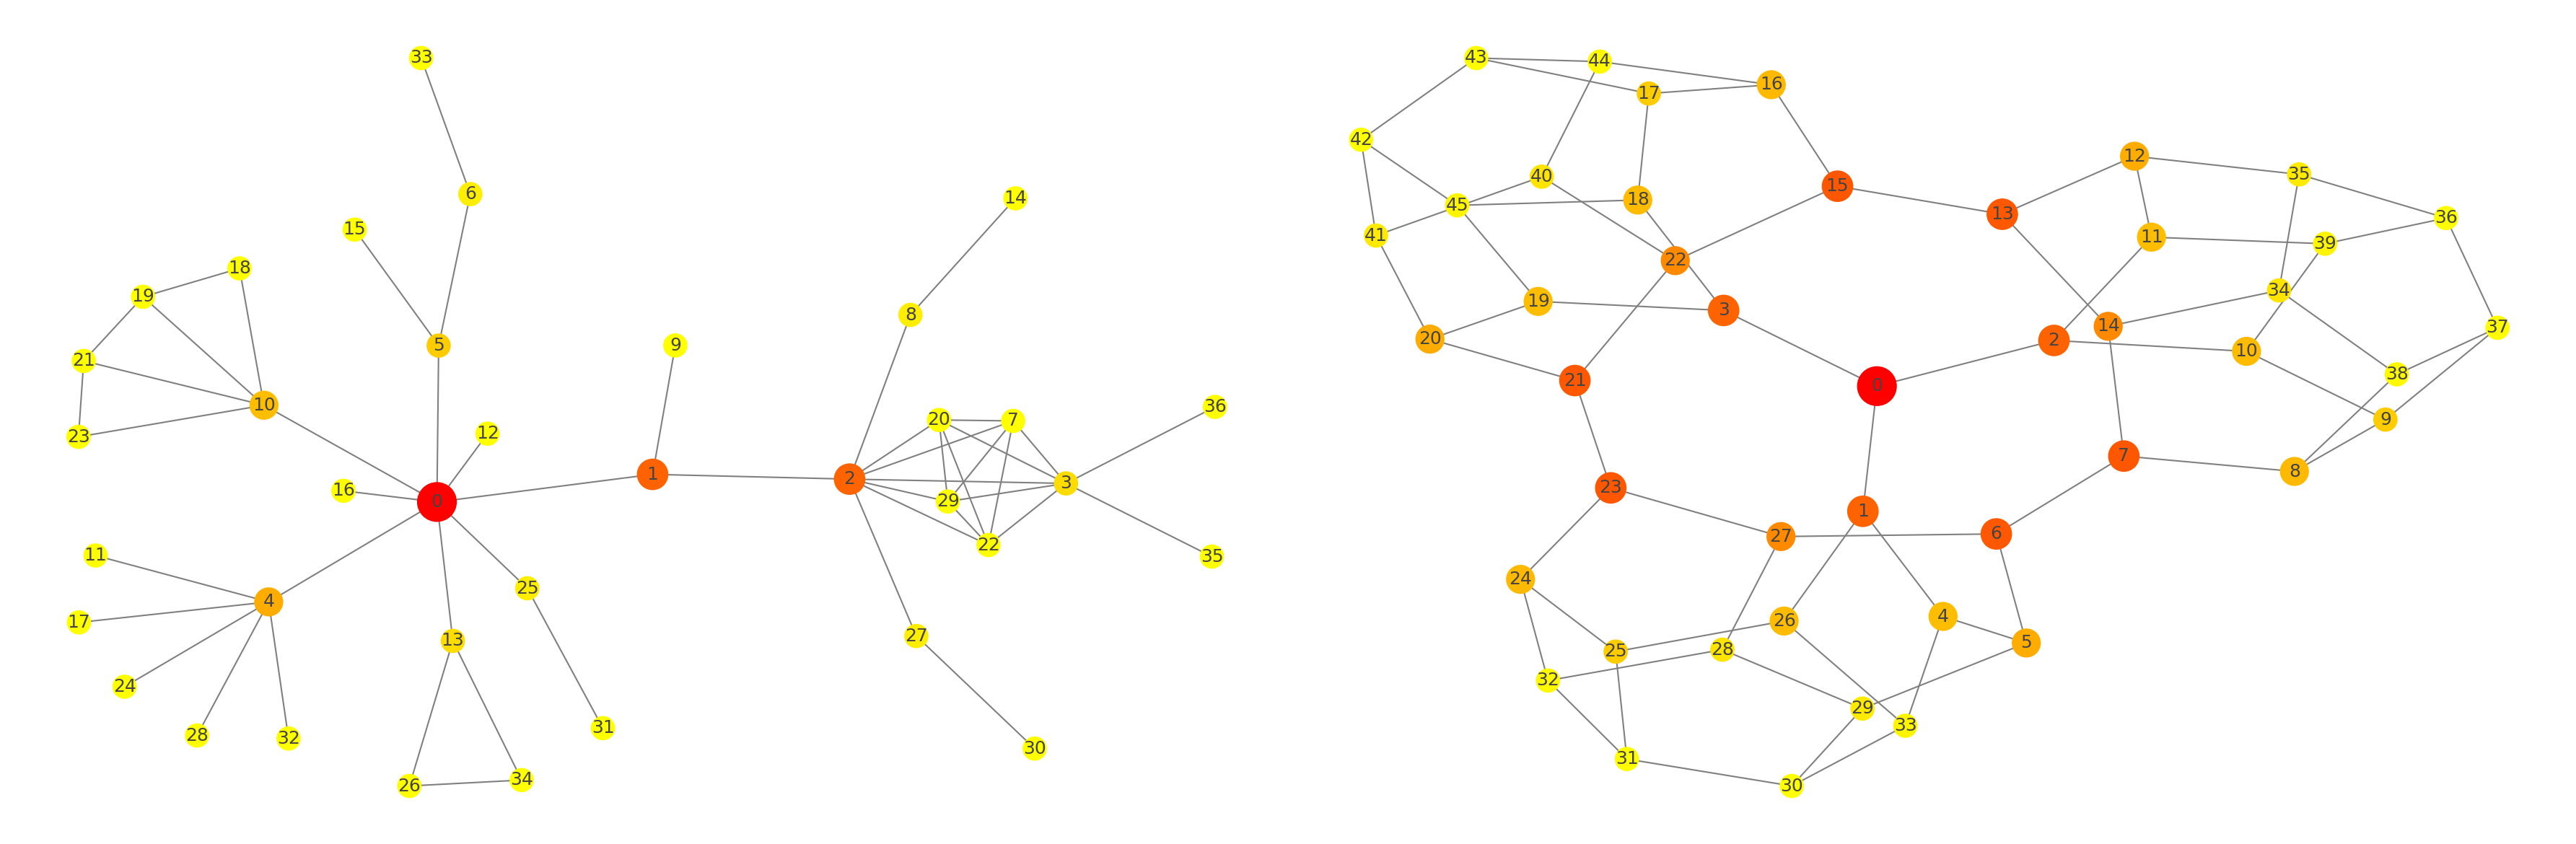

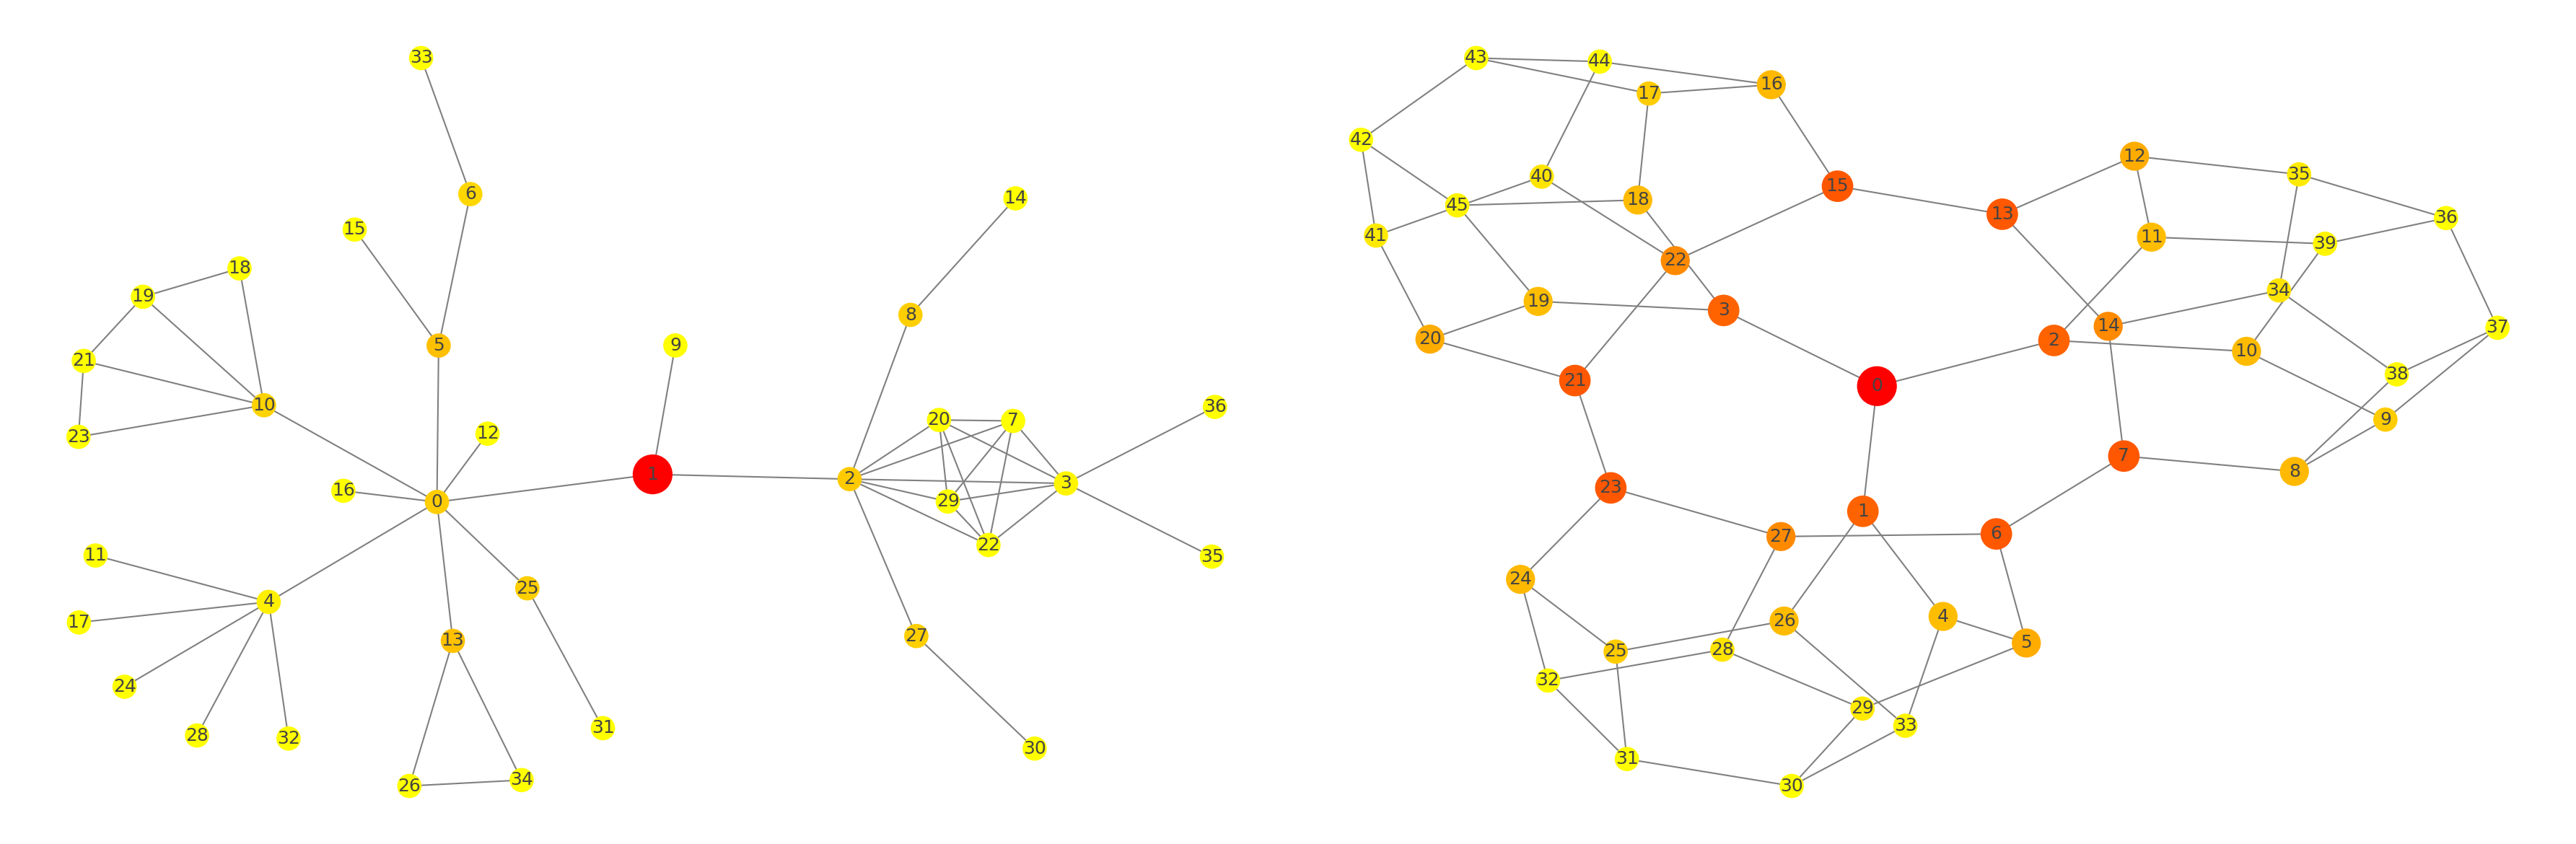

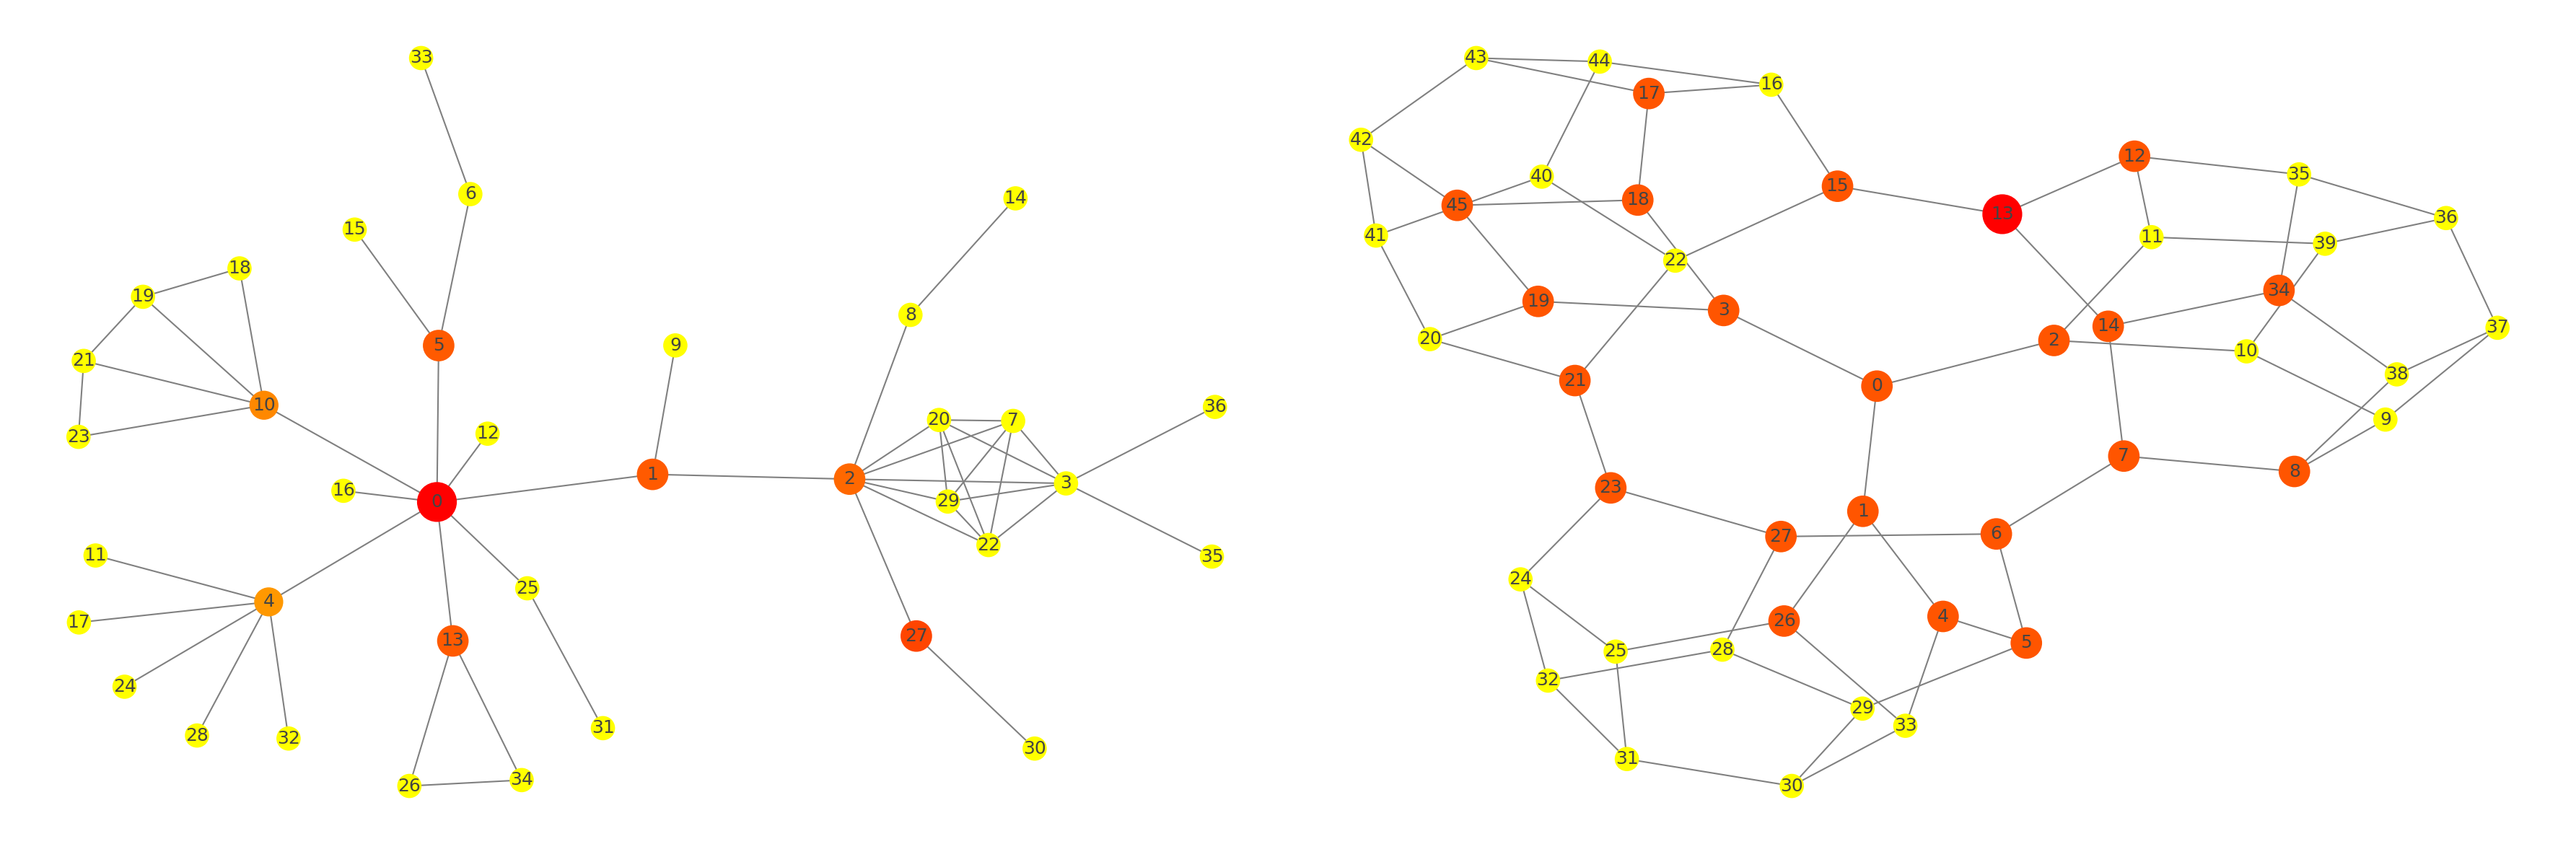

In [7]:
dictOfMeasures = plotMeasures2_Pair(sample1,sample2)

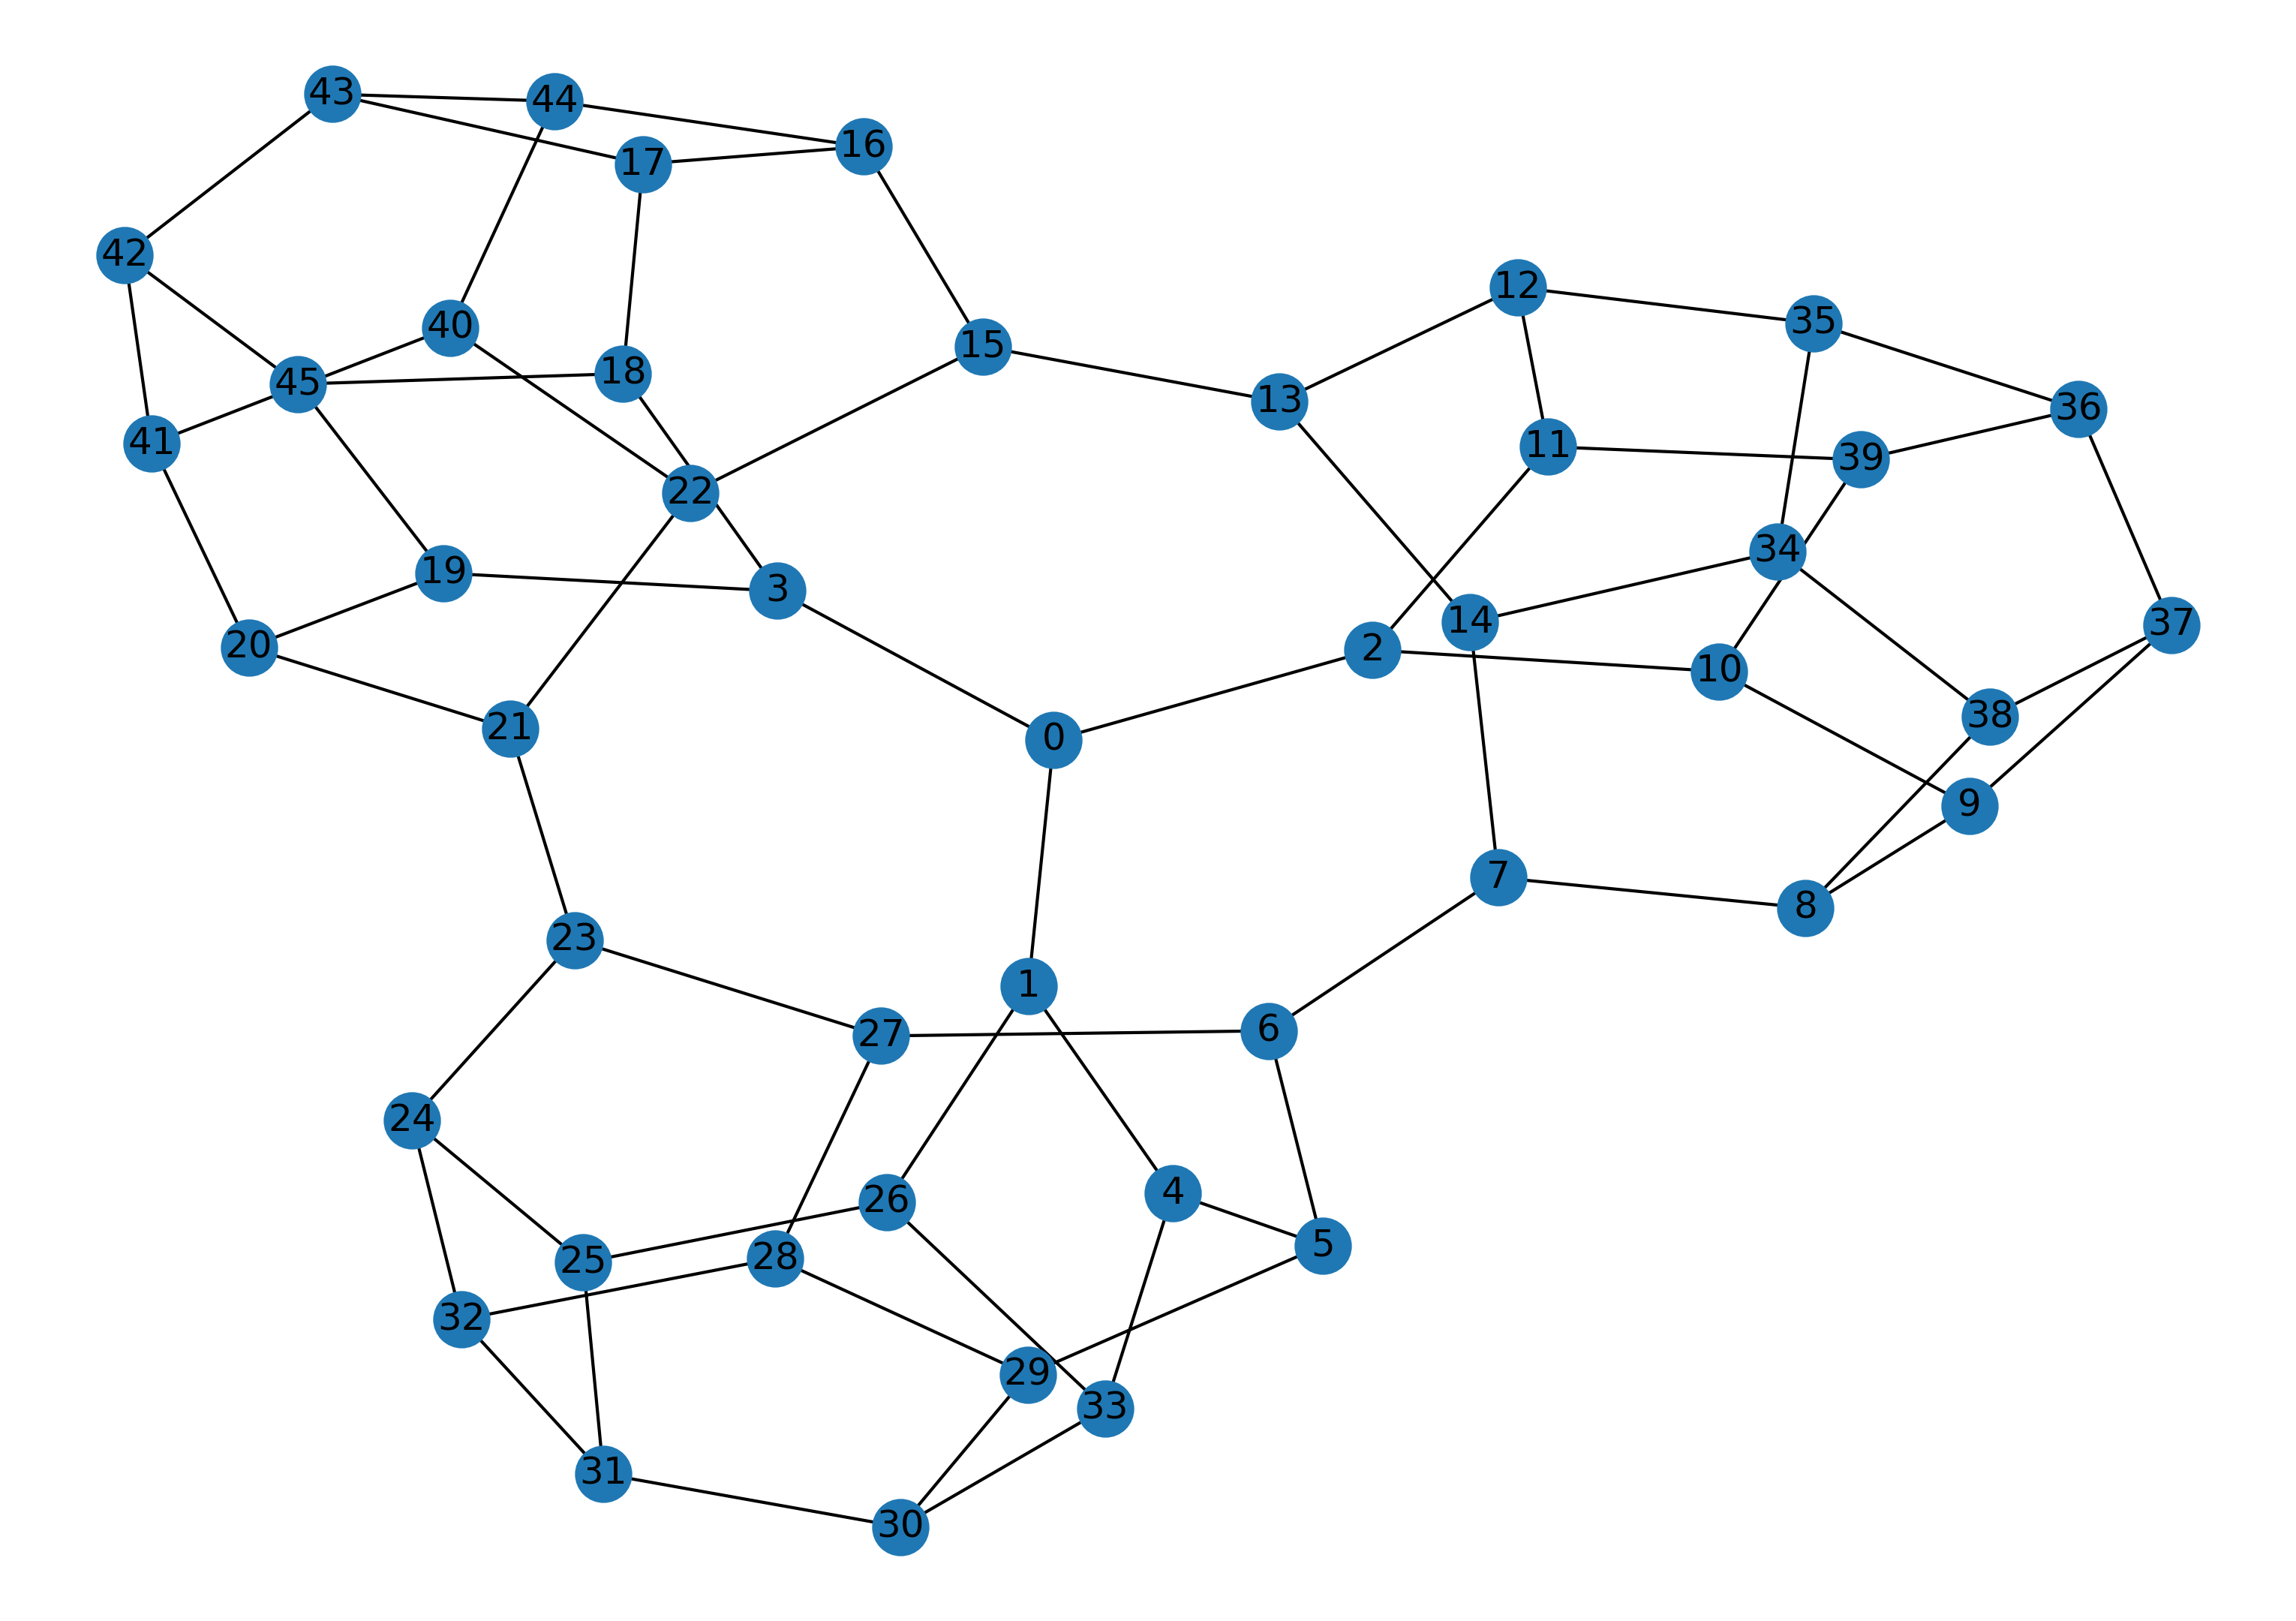

In [11]:
G=sample2.copy()
plt.figure(figsize=(10,7),dpi=300) 
for k,v in sample1.degree:
    if(v<=0):
        G.remove_node(k)
pos=nx.kamada_kawai_layout(sample2)
nx.draw(G,with_labels=1,pos=pos)
plt.show()

In [13]:
S1=networkMeasuresAsDF(sample1)

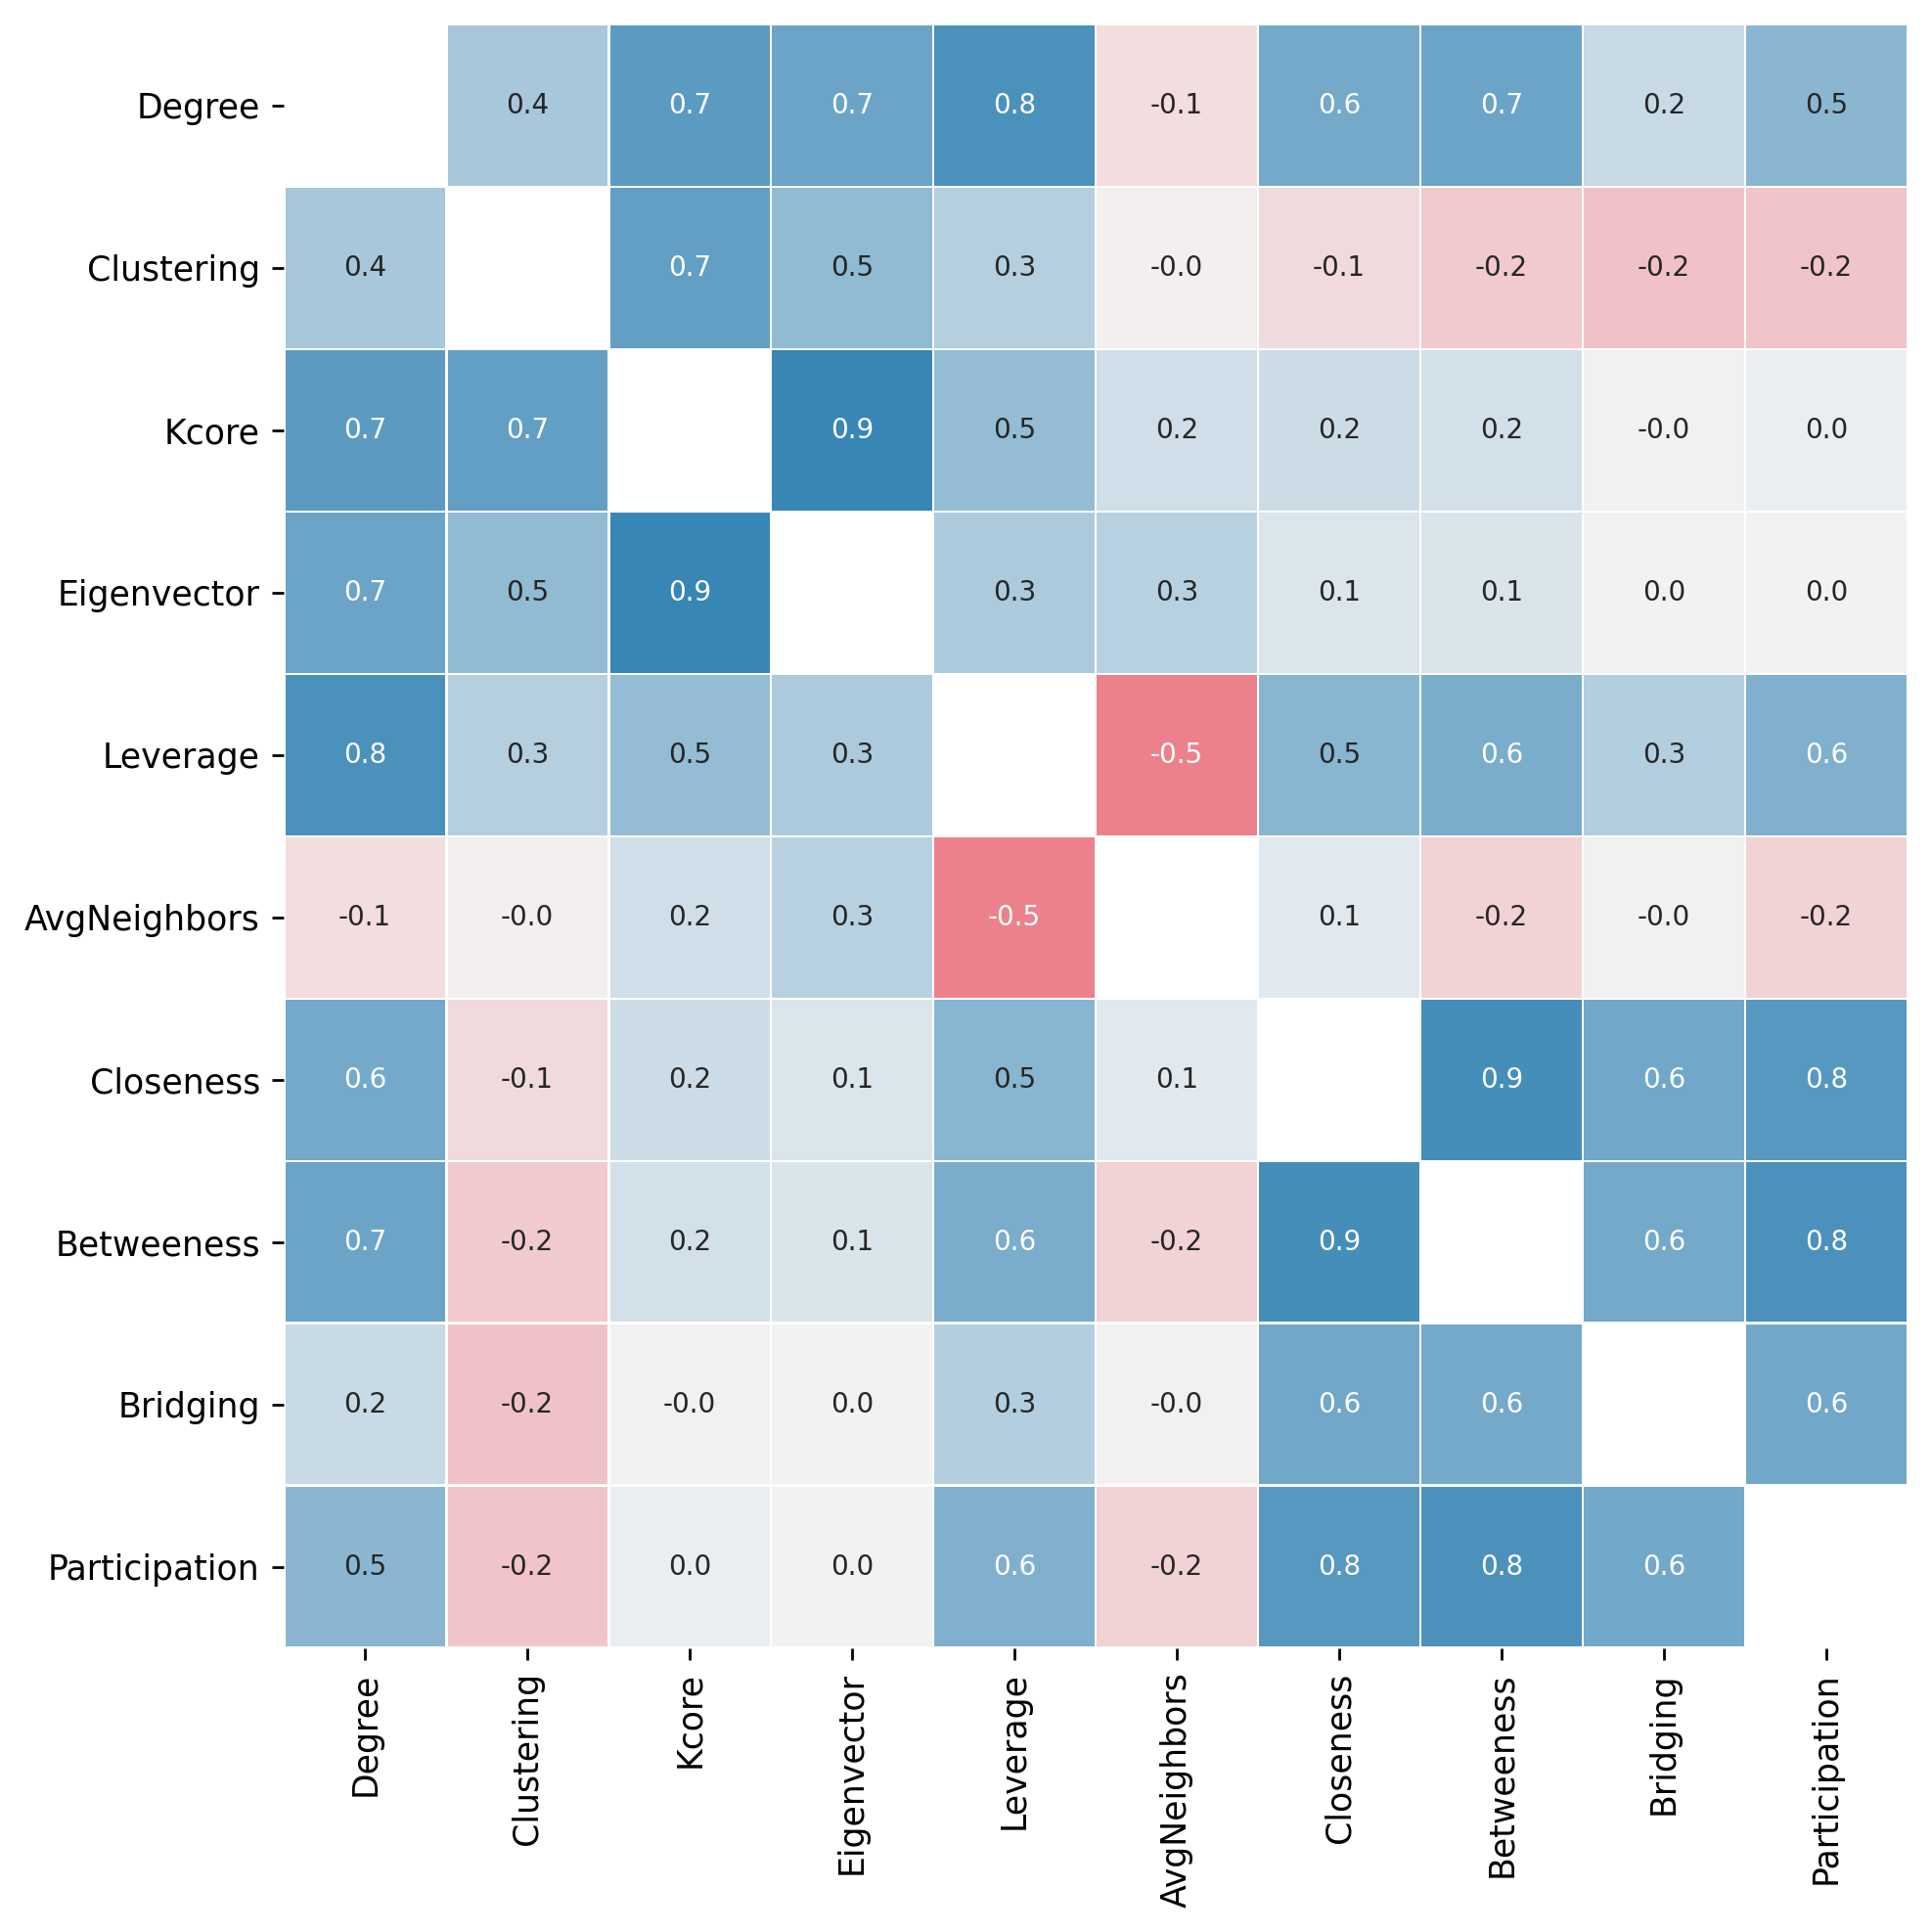

In [14]:
df=(S1-S1.min())/(S1.max()-S1.min())
df_corr = df.corr()
for col in df_corr.columns:
    df_corr.loc[col][col]=np.nan


plt.figure(figsize=(8,8),dpi=250)
cmap = sns.diverging_palette(10,240,90, as_cmap=True)
sns.heatmap(df_corr,annot=True, fmt=".1f", 
           linewidths=0.5, cmap=cmap, vmin=-1, vmax=1, 
           cbar=False, square=True,annot_kws={"size": 8})
plt.tight_layout()
plt.savefig("ouput/2.2.2 Correlation.png", format='png', dpi=550)
plt.savefig("ouput/2.2.2 Correlation.pdf", format='pdf')
plt.show()

In [30]:
S1=networkMeasuresAsDF(sample1)
S1.rename_axis('Node',inplace=True)
S2=networkMeasuresAsDF(sample2)
S2.rename_axis('Node',inplace=True)

In [21]:
communities = community.greedy_modularity_communities(sample1)
numberOfModules = len(communities)
communities

[frozenset({2, 3, 7, 8, 14, 20, 22, 29, 35, 36}),
 frozenset({0, 1, 9, 12, 16, 25, 31}),
 frozenset({4, 11, 17, 24, 28, 32}),
 frozenset({10, 18, 19, 21, 23}),
 frozenset({5, 6, 15, 33}),
 frozenset({13, 26, 34}),
 frozenset({27, 30})]

In [18]:
communities2=community.girvan_newman(sample1)
for com in communities2:
    print(len(com),com,end="\n\n")

2 ({0, 4, 5, 6, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 28, 31, 32, 33, 34}, {1, 2, 3, 35, 36, 7, 8, 9, 14, 20, 22, 27, 29, 30})

3 ({0, 33, 34, 5, 6, 10, 12, 13, 15, 16, 18, 19, 21, 23, 25, 26, 31}, {1, 2, 3, 35, 36, 7, 8, 9, 14, 20, 22, 27, 29, 30}, {32, 4, 11, 17, 24, 28})

4 ({0, 33, 34, 5, 6, 12, 13, 15, 16, 25, 26, 31}, {1, 2, 3, 35, 36, 7, 8, 9, 14, 20, 22, 27, 29, 30}, {32, 4, 11, 17, 24, 28}, {10, 18, 19, 21, 23})

5 ({0, 34, 12, 13, 16, 25, 26, 31}, {1, 2, 3, 35, 36, 7, 8, 9, 14, 20, 22, 27, 29, 30}, {32, 4, 11, 17, 24, 28}, {33, 5, 6, 15}, {10, 18, 19, 21, 23})

6 ({0, 34, 12, 13, 16, 25, 26, 31}, {1, 9}, {2, 3, 35, 36, 7, 8, 14, 20, 22, 27, 29, 30}, {32, 4, 11, 17, 24, 28}, {33, 5, 6, 15}, {10, 18, 19, 21, 23})

7 ({0, 34, 12, 13, 16, 25, 26, 31}, {1, 9}, {2, 3, 35, 36, 7, 20, 22, 27, 29, 30}, {32, 4, 11, 17, 24, 28}, {33, 5, 6, 15}, {8, 14}, {10, 18, 19, 21, 23})

8 ({0, 34, 12, 13, 16, 25, 26, 31}, {1, 9}, {2, 3, 35, 36, 7, 20, 22, 29}, {32, 4, 11, 17, 24,